# Fourth attempt at a world model
## Basic Process

In [1]:
# Settings and setup
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

# Main Settings
ROLE = "TAGGEE"
PRED_FRAMES_IN_ADVANCE = 5

# Encoder Settings
IMG_INPUT_SHAPE=(640, 640, 3)

NUM_DBS = 8
NUM_LAYERS_PER_DB = 1
NUM_FILTERS_PER_LAYER_OF_DB = 2

DOWNSCALING_LAYERS = 4
DOWNSCALING_FACTOR = 2
OUTPUT_SIZE = 64
ENC_DROPOUT = 0.25

# PREDICTOR
PRED_POSSIBLE_OUTCOMES = 8
PRED_ACTION_LAYERS = 2
PRED_ENCODED_LAYERS = 2
PRED_INTER_LAYERS = 2
PRED_INTER_LAYER_SIZE = 8 * PRED_POSSIBLE_OUTCOMES * OUTPUT_SIZE # This should scale to the number of predictions it makes and the size of each prediction
PRED_DROPOUT = 0.1

# Cost Calculator Settings
CC_INTER_LAYERS = 6
CC_INTER_LAYER_SIZE = 128
CC_DROPOUT = 0.1
CC_TOPLINE_DROPOUT = 0.5 # This dropout should address the difficulties and uncertenties of the predictors job by making this encoder provide somewhat generalizable encodings

# Action Generator Settings
ACTIONS = 1
NUM_POSSIBLE_ACTIONS = 100
ACTION_SPACE_SMOOTHING = 5
ACT_INTER_LAYERS = 2 + PRED_INTER_LAYERS + CC_INTER_LAYERS # So that it is large enough to understand the other two models in play
ACT_INTER_LAYER_SIZE = 1024
ACT_DROPOUT = 0.1

2023-11-10 00:56:18.771160: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-10 00:56:18.811955: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 00:56:19.652721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Encoder

In [2]:
# Image segmenter base
from tensorflow.keras import layers, models

def create_dense_block(x, num_of_layers, num_filters, kernel_size=5):
    output_layers = [x]
    for l in range(num_of_layers):
        x = layers.Conv2D(num_filters, kernel_size, activation="elu", padding="same")(x)
        output_layers.append(x)
        x = layers.Concatenate()(output_layers)
    return x

def create_transistion_down(x, layer_size_change, num_filters=None):
    if num_filters:
        x = layers.Conv2D(num_filters, 1, activation="elu", padding="same")(x)
    
    return layers.MaxPool2D(layer_size_change)(x)

# Keep track for skip connections and other things
skip_connections = []
previous_filters = [NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB]

# Num of filters: 4 (layers) * 32 (idk) + 64 (previous filters)
# Should prob figure out why this is

model_in = layers.Input(shape=IMG_INPUT_SHAPE)
x = layers.Conv2D(previous_filters[-1], 9, activation="elu", padding="same")(model_in)

for i in range(NUM_DBS):
    previous_filters.append(NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB + previous_filters[-1])
    x = create_dense_block(x, NUM_LAYERS_PER_DB, previous_filters[-1])
    skip_connections.append(x)
    x = create_transistion_down(x, 2, num_filters=(previous_filters[-1]))


previous_filters.append(NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB + previous_filters[-1])
x = create_dense_block(x, NUM_LAYERS_PER_DB, previous_filters[-1]) 

dense_net = models.Model(model_in, x)

dense_net.summary()

2023-11-10 00:56:23.608197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22161 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute capability: 8.9
2023-11-10 00:56:23.608709: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22451 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 640, 640, 2)          488       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 640, 640, 4)          204       ['conv2d[0][0]']              
                                                                                                  
 concatenate (Concatenate)   (None, 640, 640, 6)          0         ['conv2d[0][0]',              
                                                                     'conv2d_1[0][0]']        

In [3]:
# Encoder (Simple downscaler)

# Added encoder to flatten dense_net
encoder = models.Sequential()
encoder.add(layers.Input(shape=IMG_INPUT_SHAPE))
encoder.add(layers.RandomFlip())
encoder.add(dense_net)
encoder.add(layers.Flatten())

for i in range(DOWNSCALING_LAYERS + 1):
    encoder.add(layers.Dense(DOWNSCALING_FACTOR**(DOWNSCALING_LAYERS-i) * OUTPUT_SIZE, activation="elu",)) # kernel_regularizer='l2'))
    encoder.add(layers.Dropout(ENC_DROPOUT))

# encoder.add(layers.BatchNormalization(axis=-1))
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 640, 640, 3)       0         
                                                                 
 model (Functional)          (None, 2, 2, 38)          35780     
                                                                 
 flatten (Flatten)           (None, 152)               0         
                                                                 
 dense (Dense)               (None, 1024)              156672    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

# Predictor

In [4]:
# Build new predictor model

# Handle actionspace
keys = layers.Input(shape=ACTIONS)
pred_keys = keys

for _ in range(PRED_ACTION_LAYERS):
    pred_keys = layers.Dense(PRED_INTER_LAYER_SIZE//2, activation="elu",)(pred_keys)
    pred_keys = layers.Dropout(PRED_DROPOUT)(pred_keys)

# Handle encoded frame
encoded_frame = layers.Input(shape=OUTPUT_SIZE)
pred_frame = encoded_frame

for _ in range(PRED_ENCODED_LAYERS):
    pred_frame = layers.Dense(PRED_INTER_LAYER_SIZE//2, activation="elu",)(pred_frame)
    pred_frame = layers.Dropout(PRED_DROPOUT)(pred_frame)

# Combine them
predictor = tf.concat([pred_keys, pred_frame], axis=-1)
for _ in range(PRED_INTER_LAYERS):
    predictor = layers.Dense(PRED_INTER_LAYER_SIZE, activation="elu",)(predictor)
    predictor = layers.Dropout(PRED_DROPOUT)(predictor)

predictor = layers.Dense(PRED_POSSIBLE_OUTCOMES * OUTPUT_SIZE, activation="elu")(predictor)
predictor = tf.reshape(predictor, (tf.shape(keys)[0], PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
# predictor = layers.BatchNormalization(axis=-1)(predictor)

predictor = models.Model([keys, encoded_frame], predictor)
predictor.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 dense_5 (Dense)             (None, 2048)                 4096      ['input_3[0][0]']             
                                                                                                  
 dense_7 (Dense)             (None, 2048)                 133120    ['input_4[0][0]']             
                                                                                            

# Cost Calculator

In [5]:
cost_calculator = models.Sequential()
cost_calculator.add(layers.Input(shape=OUTPUT_SIZE))
cost_calculator.add(layers.Dropout(CC_TOPLINE_DROPOUT))

# Add internal layers
for _ in range(CC_INTER_LAYERS):
    cost_calculator.add(layers.Dense(CC_INTER_LAYER_SIZE, activation="elu",)) # kernel_regularizer='l2'))
    cost_calculator.add(layers.Dropout(CC_DROPOUT))

cost_calculator.add(layers.Dense(CC_INTER_LAYER_SIZE//2)) #, activation="elu"))
cost_calculator.add(layers.Dense(CC_INTER_LAYER_SIZE//4)) #, activation="elu"))
cost_calculator.add(layers.Dense(1, activation="sigmoid")) #, activation="elu"))

cost_calculator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dropout_14 (Dropout)        (None, 128)              

# Training

In [6]:
# Settings
ENCODER_AND_COST_AND_PRED_LR = 1 * 10**-4
COST_LR = 5 * 10**-5
PRED_LR = 5 * 10**-6

MAX_EPOCHS = 200
BATCH_SIZE = 16

1697413155
1697412997
1697413524
1697413673
1697413275
1697413670
1697413914
1697413602
1697413584
1697413127
1697413428
1697413626
1697413658
1697413280
1697413499
1697413058
1697413186
1697413302
1697413421
1697413191
1697413459
1697413017
1697413622
1697413232
1697413442
1697413176
1697413056
1697413537
1697413060
1697413377
1697413473
1697413194
1697413632
1697413663
1697413077
1697413412
1697413221
1697413424
1697413593
1697413172
1697413434
1697413003
1697413492
1697413436
1697413098
1697413630
1697413596
1697413173
1697413628
1697413930
1697413346
1697413043
1697413371
1697413170
1697413242
1697413374
1697413251
1697413306
1697413615
1697413369
1697413645
1697413120
1697413281
1697413162
1697413272
1697413087
1697413248
1697413265
1697413446
1697413509
1697413901
1697413590
1697413565
1697413511
1697413101
(9159, 2) (1, 2)
tf.Tensor([9159  640  640    3], shape=(4,), dtype=int32) tf.Tensor([9159    1], shape=(2,), dtype=int32) tf.Tensor([9159    1], shape=(2,), dtype=int32) tf.T

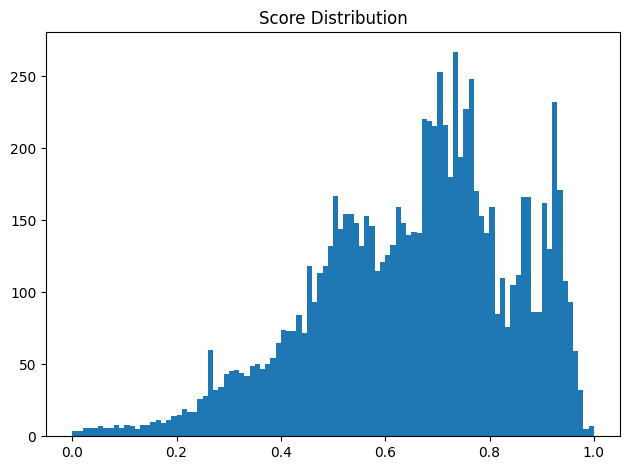

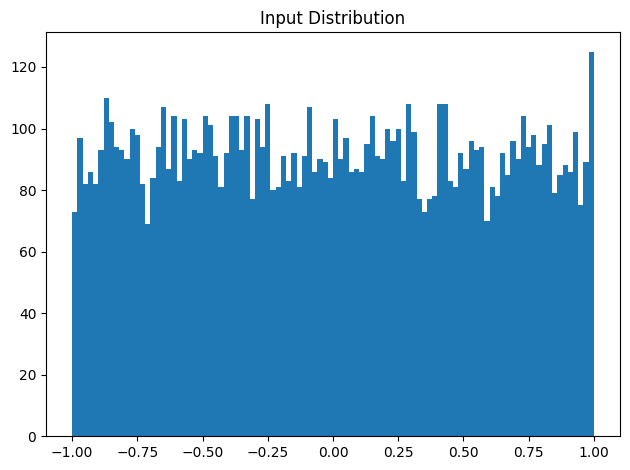

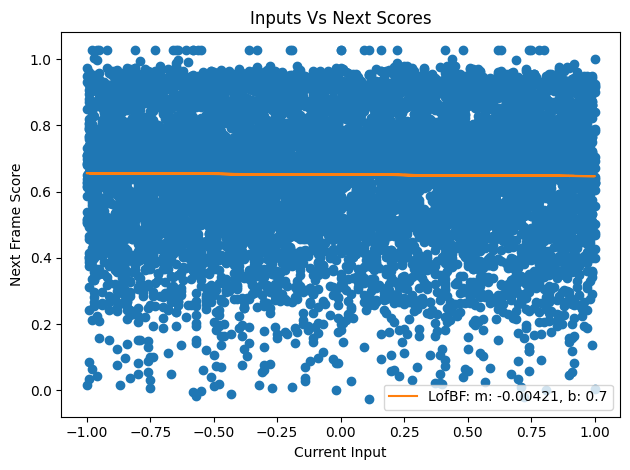

In [16]:
# Create dataset
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import numpy as np

with tf.device("cpu:0"):
    runs = pd.read_csv("game_runs.csv")[["Run", "Winner"]].sample(frac=1).values.tolist()
    all_frames = []
    all_next_frames = []
    all_input = []
    all_scores = []
    all_tagger_poses = []
    all_taggee_poses = []
    for run, winner in runs[:75]:
        frames = tf.cast(tf.io.parse_tensor(tf.io.read_file("runs/%d/frames.proto_tensor" % run), tf.uint8), tf.float16)/255.0
        all_frames.append(frames)
    
        if ROLE == "TAGGER":
            all_input.append(tf.io.parse_tensor(tf.io.read_file("runs/%d/tagger_inputs.proto_tensor" % run), float))
        else:
            all_input.append(tf.io.parse_tensor(tf.io.read_file("runs/%d/tagee_inputs.proto_tensor" % run), float))
    
        tagger_poses = tf.io.parse_tensor(tf.io.read_file("runs/%d/tagger_poses.proto_tensor" % run), float)
        taggee_poses = tf.io.parse_tensor(tf.io.read_file("runs/%d/taggee_poses.proto_tensor" % run), float)

        all_tagger_poses.append(tagger_poses)
        all_taggee_poses.append(taggee_poses)
        
        scores_normalizer = tf.math.sqrt(tf.cast(tf.math.square(IMG_INPUT_SHAPE[0]) + tf.math.square(IMG_INPUT_SHAPE[1]), float))
        
        if ROLE == "TAGGER":
            scores = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(tagger_poses - taggee_poses), axis=1))/scores_normalizer
        else:
            scores = (scores_normalizer - tf.math.sqrt(tf.math.reduce_sum(tf.math.square(tagger_poses - taggee_poses), axis=1)))/scores_normalizer
        
        if winner != ROLE:
            # Set all last scores to be 1
            # scores = tf.concat([scores[:-5:], tf.repeat(tf.constant([1.0]), repeats=5)], axis=0)
            
            # Make scores at the end more linear
            dist = 1.0 - scores[-5].numpy()
            smoothed_end = [scores[-5].numpy() + (dist / 5 * (i + 1)) for i in range(5)]
            scores = tf.concat([scores[:-5:], tf.constant(smoothed_end, float)], axis=0)

        all_scores.append(scores)
        print(run)

    # all_next_frames = tf.concat([frame[PRED_FRAMES_IN_ADVANCE:] for frame in all_frames], axis=0)
    all_frames = tf.concat([frame[:-PRED_FRAMES_IN_ADVANCE] for frame in all_frames], axis=0)
    all_input = tf.cast(tf.concat([input[:-PRED_FRAMES_IN_ADVANCE] for input in all_input], axis=0), tf.float16)
    all_future_scores = tf.cast(tf.concat([score[PRED_FRAMES_IN_ADVANCE:] for score in all_scores], axis=0), tf.float16)
    all_scores = tf.cast(tf.concat([score[:-PRED_FRAMES_IN_ADVANCE] for score in all_scores], axis=0), tf.float16)

    all_tagger_poses = tf.cast(tf.concat([pos[:-PRED_FRAMES_IN_ADVANCE] for pos in all_tagger_poses], axis=0), tf.float16)
    all_taggee_poses = tf.cast(tf.concat([pos[:-PRED_FRAMES_IN_ADVANCE] for pos in all_taggee_poses], axis=0), tf.float16)

    # Normalize scores
    scaler = RobustScaler()
    all_scores = tf.expand_dims(all_scores, axis=-1)
    all_scores = tf.numpy_function(lambda x: scaler.fit_transform(x), [all_scores], float)
    all_scores_min, all_scores_max = tf.math.reduce_min(all_scores, keepdims=True), tf.math.reduce_max(all_scores, keepdims=True)
    all_scores = (all_scores - all_scores_min) / (all_scores_max - all_scores_min)
    all_scores = tf.cast(all_scores, tf.float16)

    # Normalize future scores
    all_future_scores = tf.expand_dims(all_future_scores, axis=-1)
    all_future_scores = tf.numpy_function(lambda x: scaler.transform(x), [all_future_scores], float)
    all_future_scores = (all_future_scores - all_scores_min) / (all_scores_max - all_scores_min)
    all_future_scores = tf.cast(all_future_scores, tf.float16)
    
    # Sum the inputs
    mult_inputs = tf.constant([[1, -1]], tf.float16)
    print(all_input.shape, mult_inputs.shape)
    all_input *= mult_inputs
    all_input = tf.math.reduce_sum(all_input, axis=-1, keepdims=True)

    # Round the inputs
    all_input *= 100
    all_input = tf.math.round(all_input)/100
    
    print(tf.shape(all_frames), tf.shape(all_input), tf.shape(all_scores), tf.shape(all_future_scores)) #, tf.shape(all_delta_scores))
    print(tf.math.reduce_max(all_scores), tf.math.reduce_min(all_scores)) # , tf.math.reduce_max(all_delta_scores), tf.math.reduce_min(all_delta_scores))

    # Plot histogram of scores
    plt.hist(all_scores[:, 0].numpy(), bins=100)
    plt.title("Score Distribution")
    plt.tight_layout()
    plt.show()

    # Plot histogram of input
    plt.hist(all_input[:, 0].numpy(), bins=100)
    plt.title("Input Distribution")
    plt.tight_layout()
    plt.show()

    # Plot how inputs relate to scores
    plt.scatter(all_input[:, 0].numpy(), all_future_scores[:, 0].numpy())
    a, b = np.polyfit(all_input[:, 0].numpy().astype(float), all_future_scores[:, 0].numpy().astype(float), 1)
    plt.plot(all_input[:, 0].numpy(), a*all_input[:, 0].numpy()+b, label="LofBF: m: %.5f, b: %.1f" % (a, b), c="tab:orange")
    plt.xlabel("Current Input")
    plt.ylabel("Next Frame Score")
    plt.title("Inputs Vs Next Scores")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # plt.hist(all_delta_scores[:, 0].numpy(), bins=100)
    # plt.title("Delta Score Distribution")
    # plt.show()

    # Make DS
    big_train_ds = tf.data.Dataset.from_tensor_slices((all_frames, all_input, all_scores, all_future_scores)) # , all_delta_scores))
    big_train_ds = big_train_ds.shuffle(big_train_ds.cardinality())
    big_valid_ds = big_train_ds.shard(10, 8)
    big_test_ds = big_train_ds.shard(10, 9)
    big_train_ds = big_train_ds.take((8 * big_train_ds.cardinality())//10)

    # Make debug DS
    big_debug_train_ds = tf.data.Dataset.from_tensor_slices((all_frames, all_scores, all_tagger_poses, all_taggee_poses))
    big_debug_train_ds = big_debug_train_ds.shuffle(big_debug_train_ds.cardinality())
    big_debug_valid_ds = big_debug_train_ds.shard(10, 8)
    big_debug_test_ds = big_debug_train_ds.shard(10, 9)
    big_debug_train_ds = big_debug_train_ds.take((8 * big_debug_train_ds.cardinality())//10)

In [8]:
# Make the histogram of inputs completely even

# Approach: using a really small epison, ensure that there is only one x value within the range (-1, -1 + e), (-1 + e, -1 + 2*e), ...  The epsilon should be really really small 

In [9]:
# Train encoder, predictor, and cost calculaor together
from tensorflow.keras import optimizers

def minimum_mse(y_true, y_pred):
    se = tf.math.square(tf.expand_dims(y_true, axis=1) - y_pred)
    mse = tf.math.reduce_mean(se, axis=2) # because axis 0 is batch and 1 is the 4 predictions
    return tf.math.reduce_min(mse, axis=1) # because axis 0 is batch

def mse(y_true, y_pred):
    se = tf.math.square(tf.expand_dims(y_true, axis=1) - y_pred)
    return tf.math.reduce_mean(se, axis=[1, 2]) # Because axis 0 is batch axis

def combined_loss(y_true, y_pred, mse_weight=0.1):
    return minimum_mse(y_true, y_pred) + mse_weight * mse(y_true, y_pred)

# Comment out these two lines to train the encoder from scratch
# encoder = tf.keras.models.load_model("encoder_%s.keras" % ROLE)
# cost_calculator = tf.keras.models.load_model("cost_calculator_%s.keras" % ROLE)
# predictor = tf.keras.models.load_model("predictor_%s.keras" % ROLE)

frame_and_score = lambda w, x, y, z: (w, y)
enc_cost_calc = models.Sequential([layers.Input(shape=IMG_INPUT_SHAPE), encoder, cost_calculator])
enc_cost_calc.compile(optimizers.Adam(learning_rate=ENCODER_AND_COST_AND_PRED_LR), loss="mse", metrics=["mse"])
enc_cost_calc.summary()

train_ds_frame_and_score = big_train_ds.map(frame_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE).cache()
valid_ds_frame_and_score = big_valid_ds.map(frame_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE).cache()

frame_key_next_cost = lambda w, x, y, z: ((w, x), z)
cur_frame_in = layers.Input(shape=IMG_INPUT_SHAPE)
cur_key_in = layers.Input(shape=ACTIONS)
enc_pred_enc = encoder(cur_frame_in)
enc_pred_enc = predictor((cur_key_in, enc_pred_enc))
enc_pred_enc = tf.reshape(enc_pred_enc, (tf.shape(cur_frame_in)[0] * PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
enc_pred_enc = cost_calculator(enc_pred_enc)
enc_pred_enc = tf.reshape(enc_pred_enc, (tf.shape(cur_frame_in)[0], PRED_POSSIBLE_OUTCOMES, 1))
enc_pred_enc = models.Model([cur_frame_in, cur_key_in], enc_pred_enc)
enc_pred_enc.compile(optimizers.Adam(learning_rate=ENCODER_AND_COST_AND_PRED_LR), loss=combined_loss, metrics=[minimum_mse, mse])
enc_pred_enc.summary()

train_ds_frame_key_next_frame = big_train_ds.map(frame_key_next_cost, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE).cache()
valid_ds_frame_key_next_frame = big_valid_ds.map(frame_key_next_cost, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE).cache()

best_encoder, best_cost_calculator, best_pred = None, None, None
min_cc_losses, min_pred_losses = 10**10, 10**10

time_without_save = 0

for i in range(MAX_EPOCHS):
    train_iter_frame_and_score = iter(train_ds_frame_and_score)
    train_iter_frame_key_next_frame = iter(train_ds_frame_key_next_frame)
    
    while True:
        try:
            # Fit cost calculator and encoder to one batch
            cost_calculator.trainable = True
            data = train_iter_frame_and_score.next()
            enc_cc_loss = enc_cost_calc.train_on_batch(
                data[0], data[1]
            )

            # Fit predictor and encoder to one batch
            cost_calculator.trainable = False
            data = train_iter_frame_key_next_frame.next()
            enc_pred_enc.train_on_batch(
                data[0], data[1]
            )
        except StopIteration:
            break

    enc_cc_loss = enc_cost_calc.evaluate(valid_ds_frame_and_score, return_dict=True)["loss"]
    enc_pred_loss = enc_pred_enc.evaluate(valid_ds_frame_key_next_frame, return_dict=True)["loss"]
            
    if enc_cc_loss <= min_cc_losses and enc_pred_loss <= min_pred_losses:
        print(i, "Saving")

        min_cc_losses = enc_cc_loss
        min_pred_losses = enc_pred_loss
        
        min_cc_losses
        encoder.save("encoder_%s.keras" % ROLE)
        cost_calculator.save("cost_calculator_%s.keras" % ROLE)
        predictor.save("predictor_%s.keras" % ROLE)
        time_without_save = 0
    else:
        print(i)
        time_without_save += 1

    if time_without_save > MAX_EPOCHS//10:
        break

encoder = tf.keras.models.load_model("encoder_%s.keras" % ROLE)
cost_calculator = tf.keras.models.load_model("cost_calculator_%s.keras" % ROLE)
predictor = tf.keras.models.load_model("predictor_%s.keras" % ROLE, custom_objects={"combined_loss": combined_loss, "minimum_mse": minimum_mse, "mse": mse})

cost_calculator.trainable = True
encoder.trainable = False

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64)                889732    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 68225     
                                                                 
Total params: 957957 (3.65 MB)
Trainable params: 957957 (3.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 

2023-11-10 00:57:07.978405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-10 00:57:08.113956: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-11-10 00:57:08.113987: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-11-10 00:57:08.114082: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-10 00:57:09.117921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-10 00:57:09.135398: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f147fa8c6f

59/59 [==============================] - 5s 13ms/step - loss: 0.0199 - minimum_mse: 0.0148 - mse: 0.0508
0 Saving
59/59 [==============================] - 1s 13ms/step - loss: 0.0098 - minimum_mse: 0.0016 - mse: 0.0819
1 Saving
59/59 [==============================] - 1s 13ms/step - loss: 0.0113 - minimum_mse: 0.0020 - mse: 0.0930
2
59/59 [==============================] - 1s 13ms/step - loss: 0.0120 - minimum_mse: 0.0023 - mse: 0.0970
3
59/59 [==============================] - 1s 13ms/step - loss: 0.0090 - minimum_mse: 0.0033 - mse: 0.0569
4 Saving
59/59 [==============================] - 1s 13ms/step - loss: 0.0084 - minimum_mse: 0.0012 - mse: 0.0722
5 Saving
59/59 [==============================] - 1s 13ms/step - loss: 0.0073 - minimum_mse: 0.0011 - mse: 0.0625
6 Saving
59/59 [==============================] - 1s 13ms/step - loss: 0.0078 - minimum_mse: 0.0012 - mse: 0.0663
9
59/59 [==============================] - 1s 13ms/step - loss: 0.0071 - minimum_mse: 0.0012 - mse: 0.0594
10 S

In [10]:
# Train cost calculator without encoder and lower lr

cost_calculator.compile(optimizers.Adam(learning_rate=COST_LR), loss="mse", metrics=["mse"])
cost_calculator.summary()

encodings_and_score = lambda w, x, y, z: (encoder(w), y)

encoding_cost_train_ds = big_train_ds.batch(BATCH_SIZE).map(encodings_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()
encoding_cost_valid_ds = big_valid_ds.batch(BATCH_SIZE).map(encodings_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()

cost_calculator.fit(
    encoding_cost_train_ds,
    validation_data=encoding_cost_valid_ds,
    epochs=MAX_EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=MAX_EPOCHS//10, restore_best_weights=True)]
)

cost_calculator.save("cost_calculator_%s.keras" % ROLE)
cost_calculator.trainable = False

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dropout_14 (Dropout)        (None, 128)              

In [11]:
# Train prediction
frame_key_next_cost = lambda w, x, y, z: ((w, x), z)
cur_frame_in = layers.Input(shape=IMG_INPUT_SHAPE)
cur_key_in = layers.Input(shape=ACTIONS)
enc_pred_enc = encoder(cur_frame_in)
enc_pred_enc = predictor((cur_key_in, enc_pred_enc))
enc_pred_enc = tf.reshape(enc_pred_enc, (tf.shape(cur_frame_in)[0] * PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
enc_pred_enc = cost_calculator(enc_pred_enc)
enc_pred_enc = tf.reshape(enc_pred_enc, (tf.shape(cur_frame_in)[0], PRED_POSSIBLE_OUTCOMES, 1))
enc_pred_enc = models.Model([cur_frame_in, cur_key_in], enc_pred_enc)
enc_pred_enc.compile(optimizers.Adam(learning_rate=ENCODER_AND_COST_AND_PRED_LR), loss=combined_loss, metrics=[minimum_mse, mse])
enc_pred_enc.summary()

train_ds_frame_key_next_frame = big_train_ds.map(frame_key_next_cost, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE).cache()
valid_ds_frame_key_next_frame = big_valid_ds.map(frame_key_next_cost, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE).cache()



with tf.device("cpu:0"):
    apply_encoder = lambda w, x, y, z: ((x, tf.cast(encoder(w), tf.float16)), z)
    pred_train_ds = big_train_ds.batch(BATCH_SIZE).map(apply_encoder, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()
    pred_valid_ds = big_valid_ds.batch(BATCH_SIZE).map(apply_encoder, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()

with tf.device("gpu:0"):
    cur_frame_in = layers.Input(shape=OUTPUT_SIZE)
    cur_key_in = layers.Input(shape=ACTIONS)
    enc_pred_enc = predictor((cur_key_in, cur_frame_in))
    enc_pred_enc = tf.reshape(enc_pred_enc, (tf.shape(cur_frame_in)[0] * PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
    enc_pred_enc = cost_calculator(enc_pred_enc)
    enc_pred_enc = tf.reshape(enc_pred_enc, (tf.shape(cur_frame_in)[0], PRED_POSSIBLE_OUTCOMES, 1))
    enc_pred_enc = models.Model([cur_key_in, cur_frame_in], enc_pred_enc)
    enc_pred_enc.compile(optimizers.Adam(learning_rate=PRED_LR), loss=combined_loss, metrics=[minimum_mse, mse])
    enc_pred_enc.summary()
    
    enc_pred_enc.fit(
        pred_train_ds,
        validation_data=pred_valid_ds,
        epochs=MAX_EPOCHS,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=MAX_EPOCHS//10, restore_best_weights=True)]
    )

predictor.save("predictor_%s.keras" % ROLE)
predictor.trainable=False

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 tf.compat.v1.shape_3 (TFOp  (4,)                         0         ['input_9[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 input_10 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64)                   889732    ['input_9[0][0]']       

In [12]:
# Train action generator

@tf.function
def define_action(encoded_frames, smoothing=ACTION_SPACE_SMOOTHING, num_actions=NUM_POSSIBLE_ACTIONS, ret_predictions=False):
    actions = tf.cast(tf.expand_dims(tf.linspace(-1, 1, num_actions), axis=-1), tf.float16)
    print(tf.shape(actions))
    actions = tf.repeat(tf.expand_dims(actions, axis=0), repeats=tf.shape(encoded_frames)[0], axis=0)
    print(tf.shape(actions))

    # Now actions has shape (batch_size, num_actions, 1)
    # Make it have shape (num_actions, batch_size, 1)
    actions = tf.transpose(actions, perm=[1, 0, 2])

    predictions = tf.map_fn(
        lambda x: predictor((x, encoded_frames)),
        actions,
        fn_output_signature=tf.TensorSpec((None, PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE), float)
    )
    if ret_predictions:
        return predictions, actions

    # Above returns the predicted scores in shape (num_actions, batch_size, num_predictons, encoded_layer_size)
    # Reshape to (num_actions * batch_size * num_predictons, encoded_layer_size)
    pred_shape = tf.shape(predictions)
    predictions = tf.reshape(predictions, (pred_shape[0] * pred_shape[1] * pred_shape[2], pred_shape[3]))

    costs = cost_calculator(predictions)
    
    # Costs returned as (num_actions * batch_size * num_predictons, 1)
    # Reshape to (num_actions, batch_size, num_predictons) then (batch_size, num_actions, num_predictons) then avg to (batch_size, num_actions)
    costs = tf.reshape(costs, (pred_shape[0], pred_shape[1], pred_shape[2]))
    costs = tf.transpose(costs, perm=[1, 0, 2])
    avg_costs = tf.math.reduce_mean(costs, axis=-1)

    # Use numpy to smooth each set of actions
    smoothing_func = lambda y: tf.numpy_function(lambda x: (np.convolve(x, np.ones(smoothing), 'same')[smoothing:-smoothing]/smoothing).astype(np.single), [y], float)
    smoothed_costs = tf.map_fn(smoothing_func, avg_costs, fn_output_signature=tf.TensorSpec((num_actions - (2 * smoothing),), float))

    print(smoothed_costs)
    
    # return the argmin (normalized to actual input) of the smoothed function.  In addition, return the cost tensors
    moves = tf.expand_dims(tf.math.argmin(smoothed_costs, axis=-1), axis=-1)
    print(moves)
    moves = tf.cast(moves, tf.float16) * (actions[1] - actions[0])
    print(moves, actions[1] - actions[0])
    moves -= actions[smoothing]
    return moves, costs, smoothed_costs


class KerasGenActionLayer(layers.Layer):
    def call(self, x, training=None):
        print(tf.shape(x))
        return define_action(x, smoothing=ACTION_SPACE_SMOOTHING, num_actions=NUM_POSSIBLE_ACTIONS)[0]


inp = layers.Input(shape=IMG_INPUT_SHAPE)
action_gen = encoder(inp)
action_gen = KerasGenActionLayer()(action_gen)

action_gen = models.Model(inp, action_gen)
action_gen.track_pred_model = predictor
action_gen.track_cost_calculator = cost_calculator

action_gen.summary()
action_gen.save("action_gen_%s.tf" % ROLE, save_format="tf")

Tensor("keras_gen_action_layer/Shape:0", shape=(2,), dtype=int32)
Tensor("Shape:0", shape=(2,), dtype=int32)
Tensor("Shape_2:0", shape=(3,), dtype=int32)
Tensor("map_1/TensorArrayV2Stack/TensorListStack:0", shape=(None, 90), dtype=float32)
Tensor("ExpandDims_2:0", shape=(None, 1), dtype=int64)
Tensor("mul_2:0", shape=(None, 1), dtype=float16) Tensor("sub_1:0", shape=(None, 1), dtype=float16)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 640, 640, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 64)                889732    
                                                                 
 keras_gen_action_layer (Ke  (None, 1)                 0         
 rasGenActionLayer)                                              
                                                            

INFO:tensorflow:Assets written to: action_gen_TAGGEE.tf/assets


## Debugging

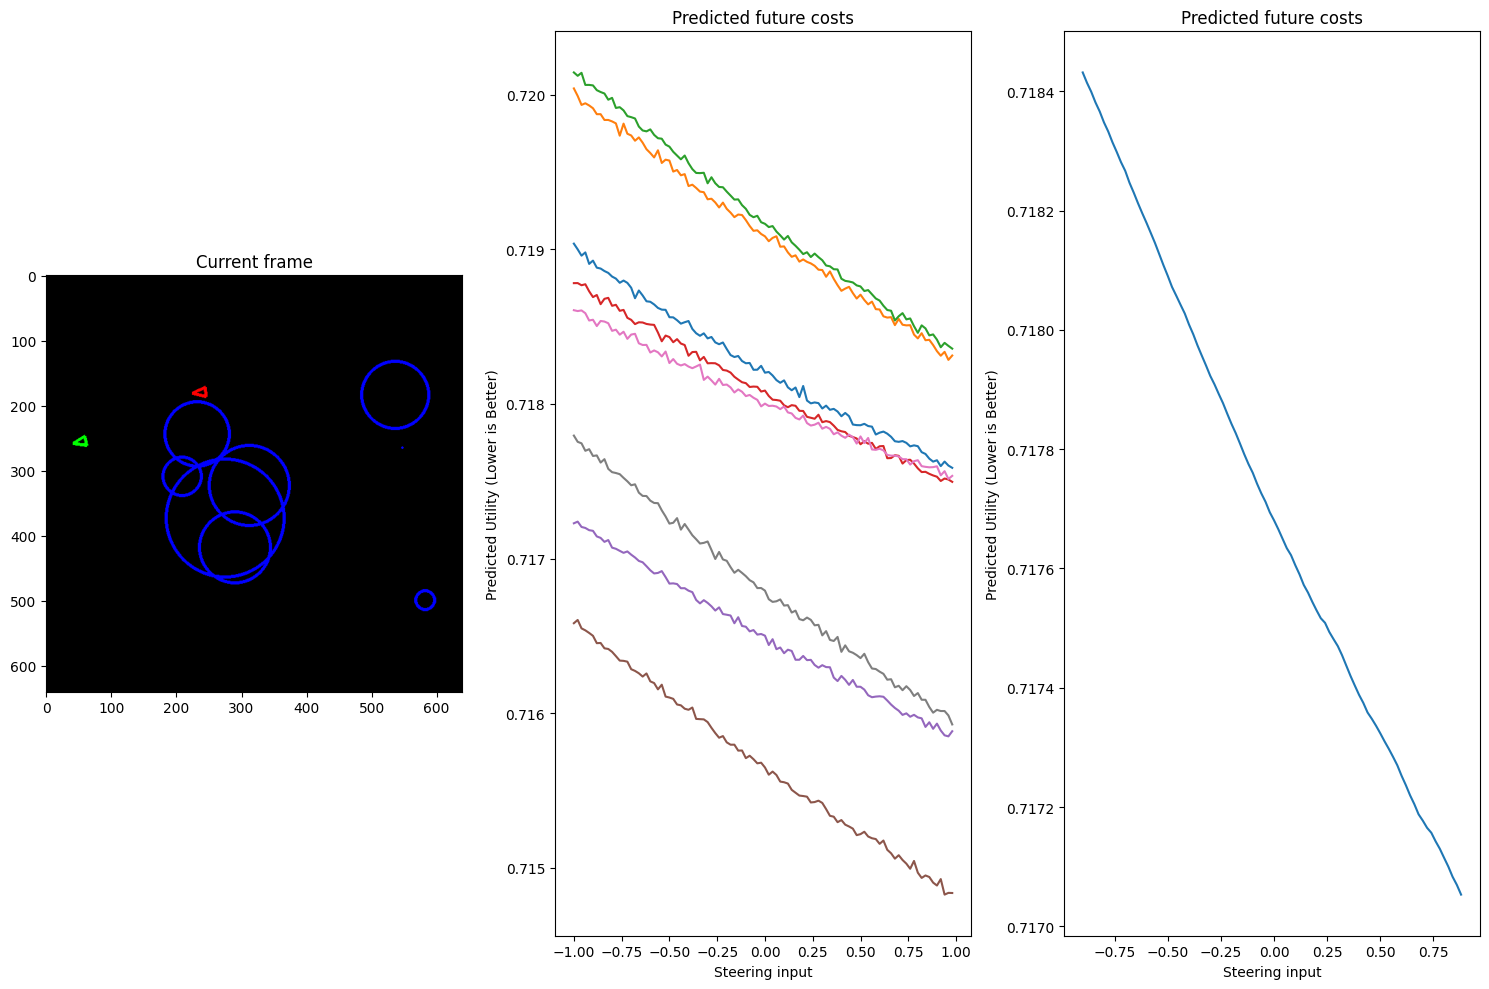

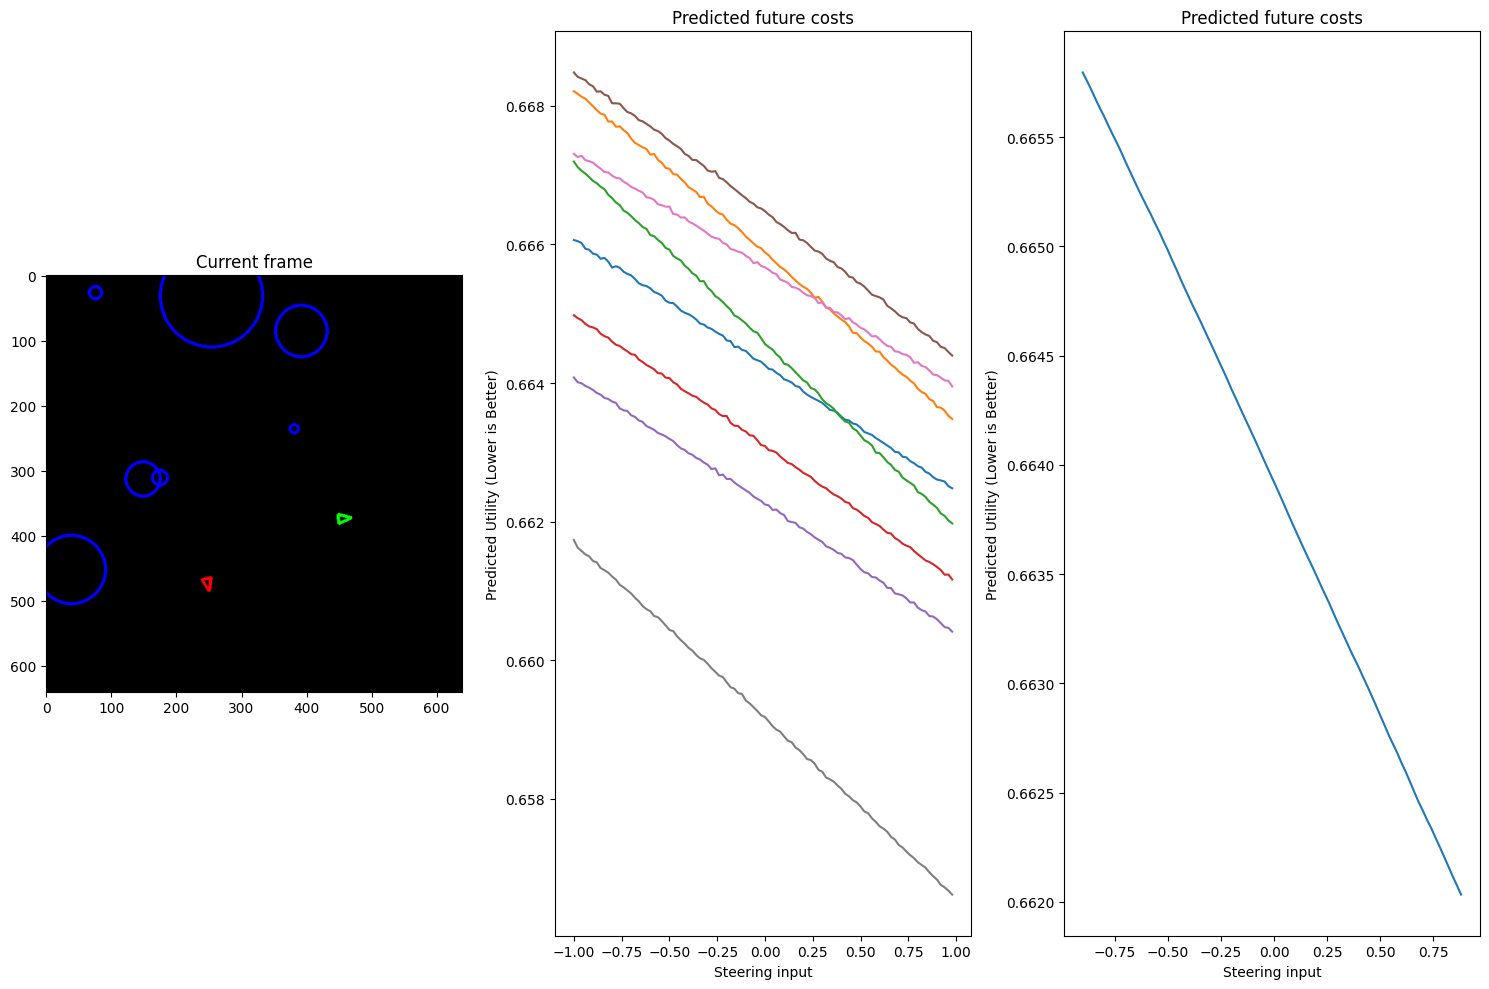

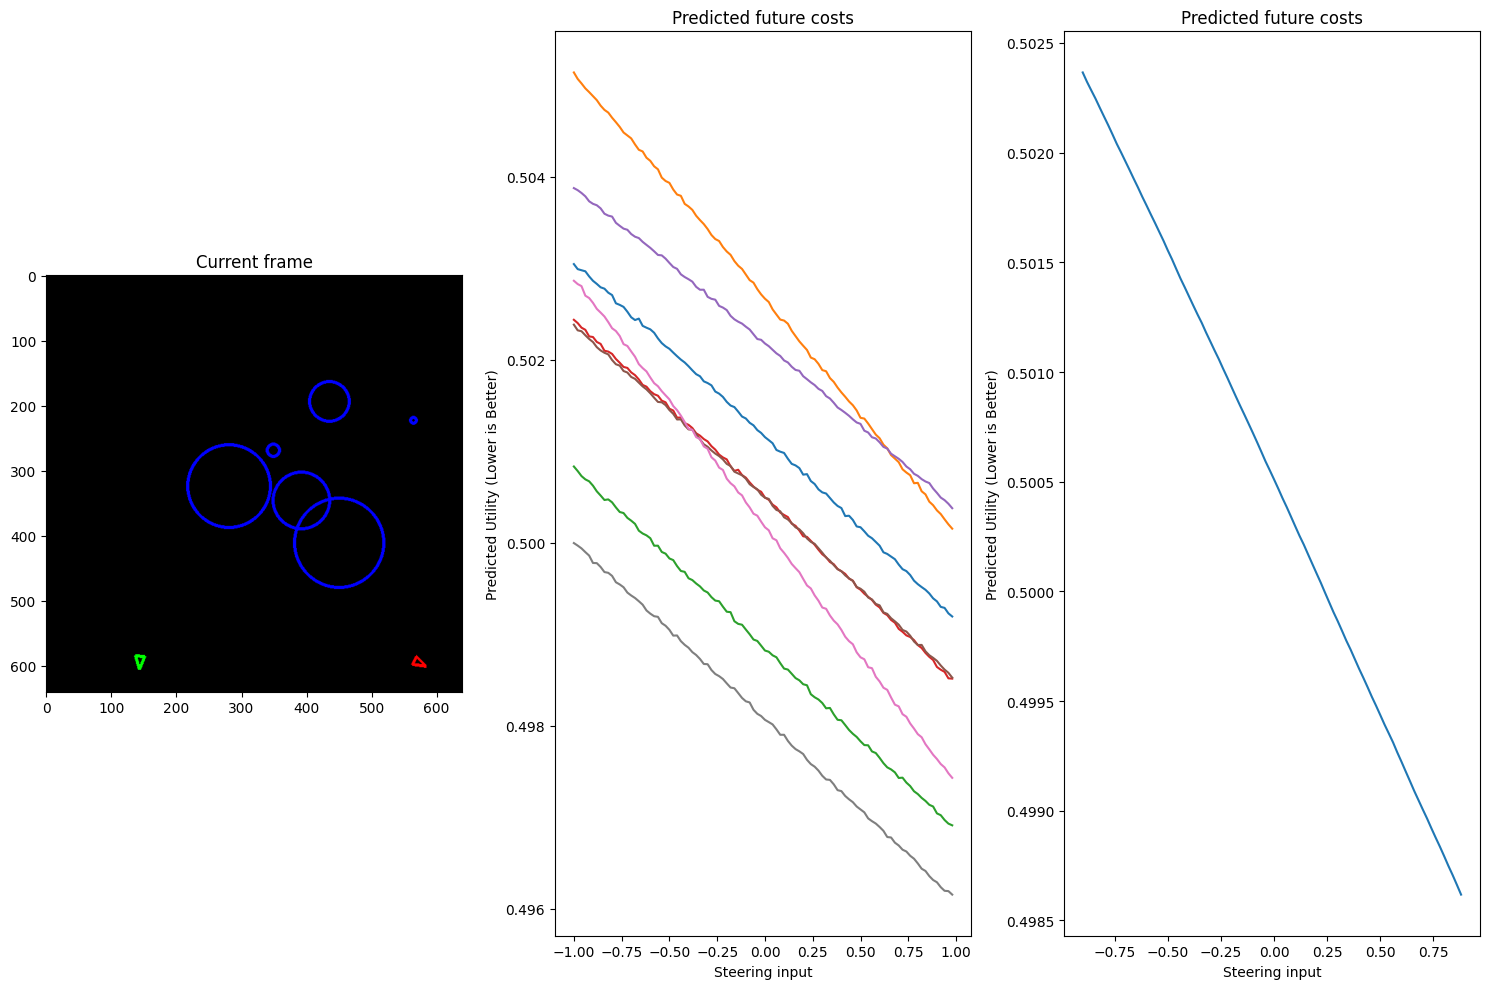

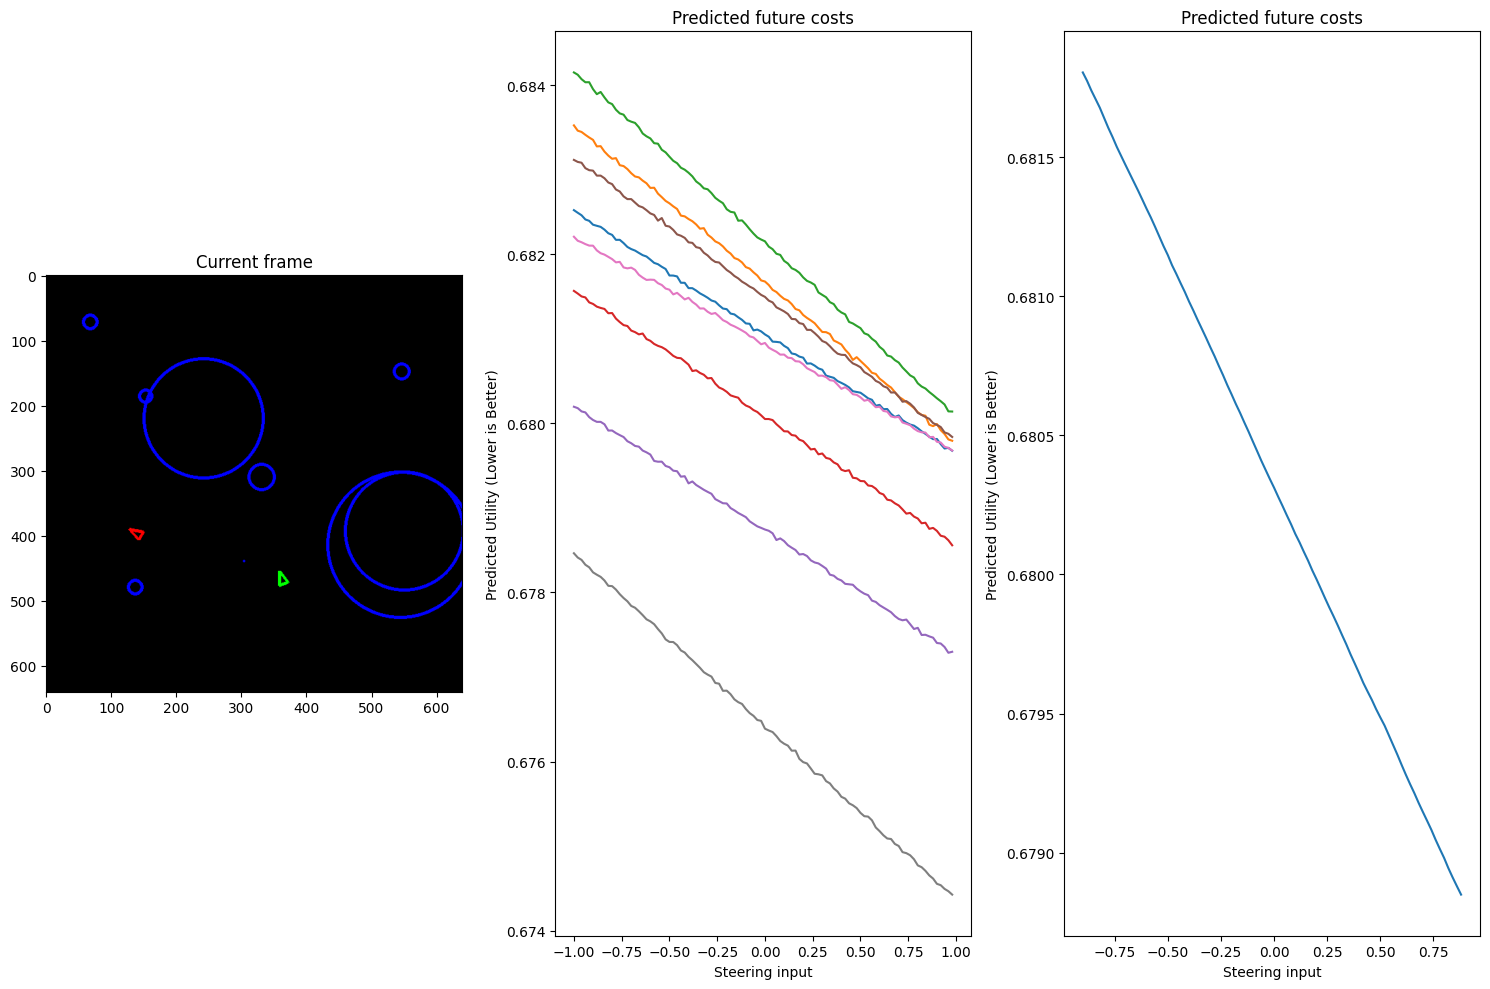

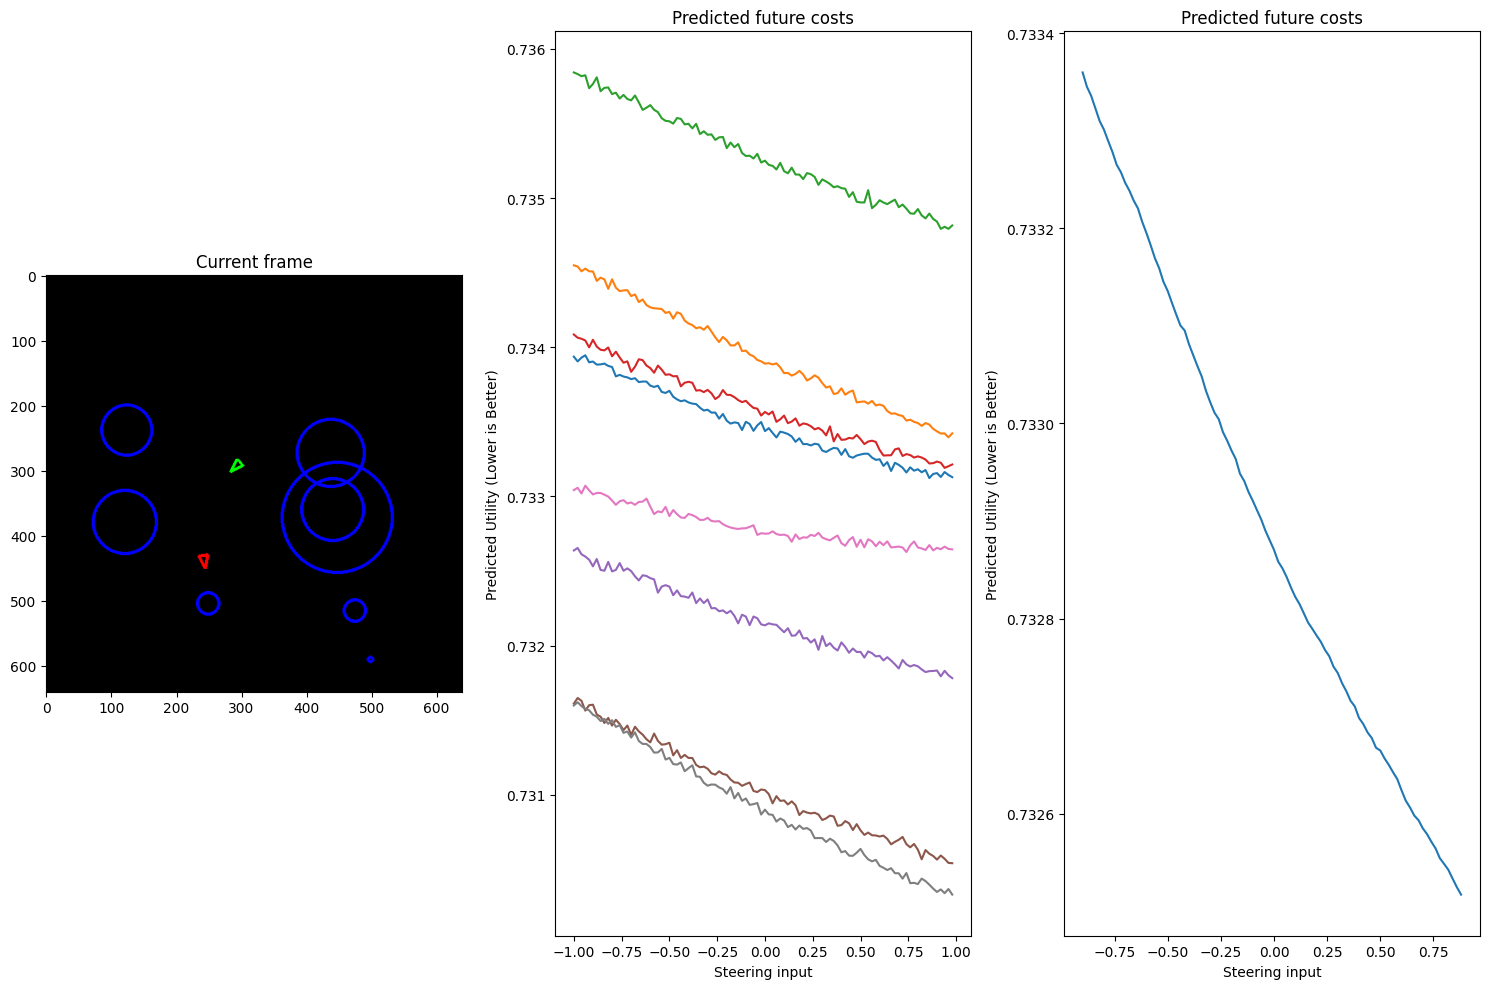

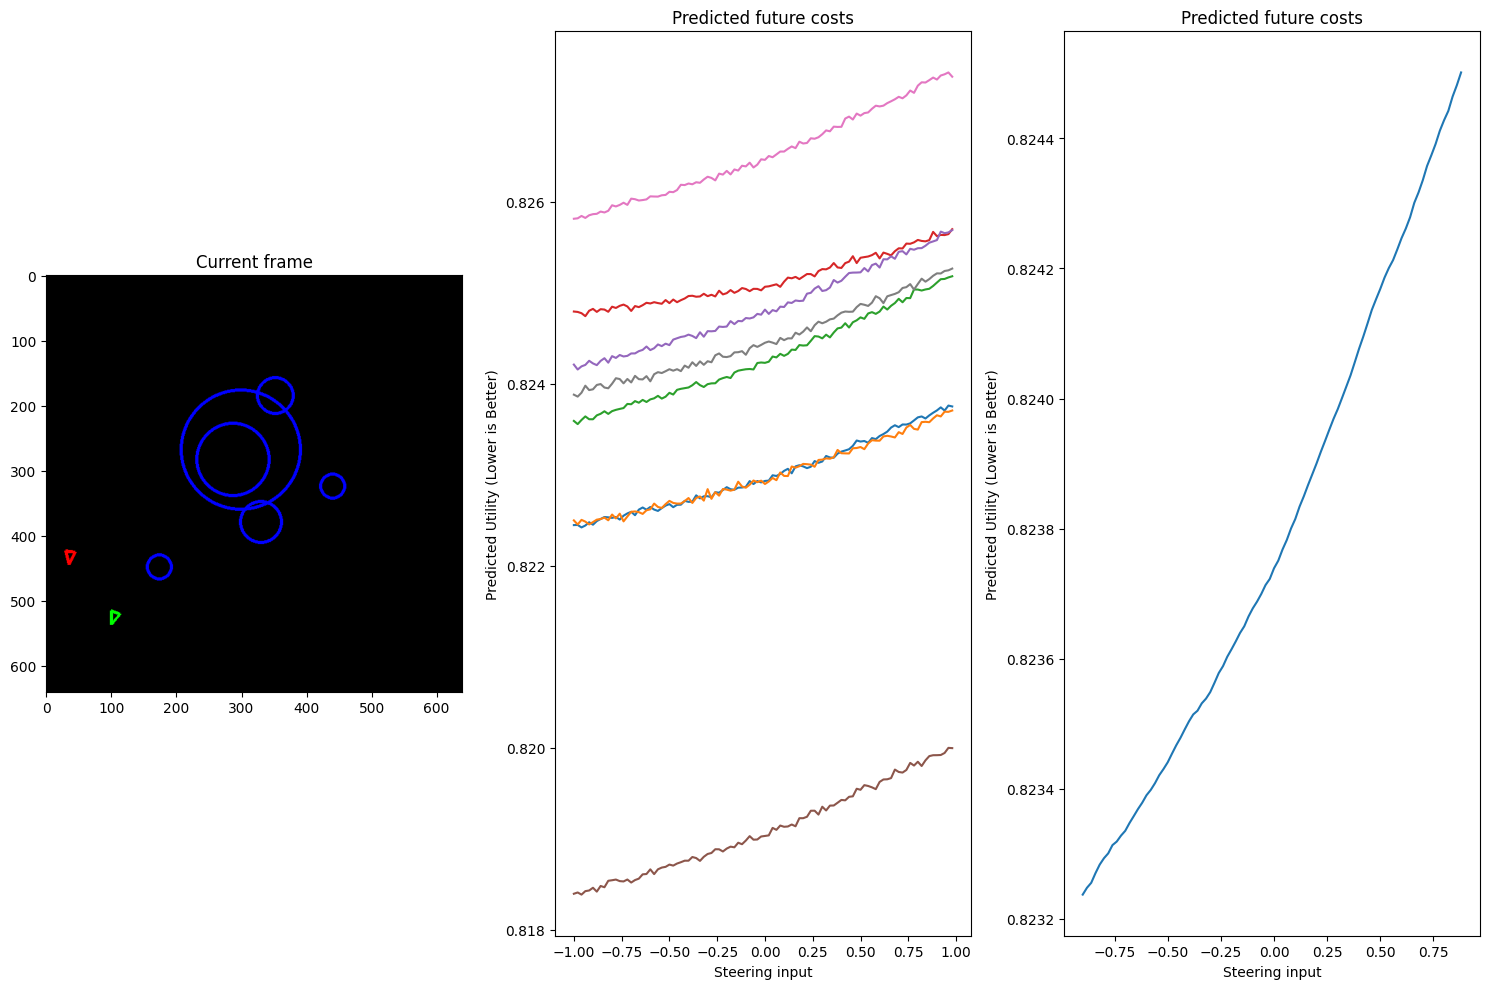

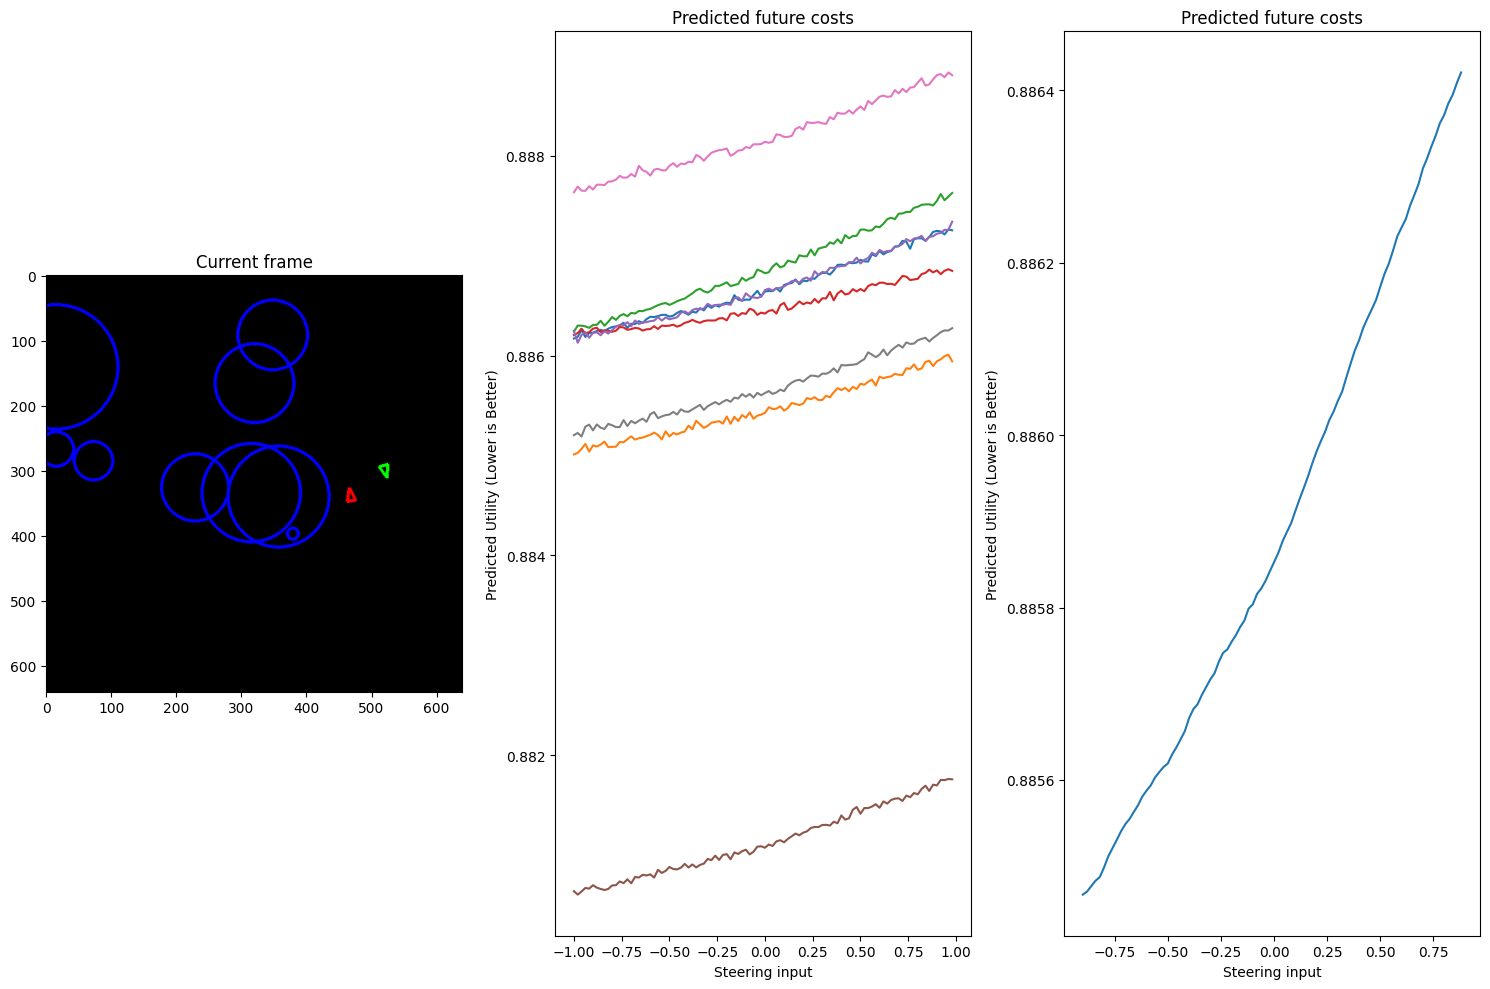

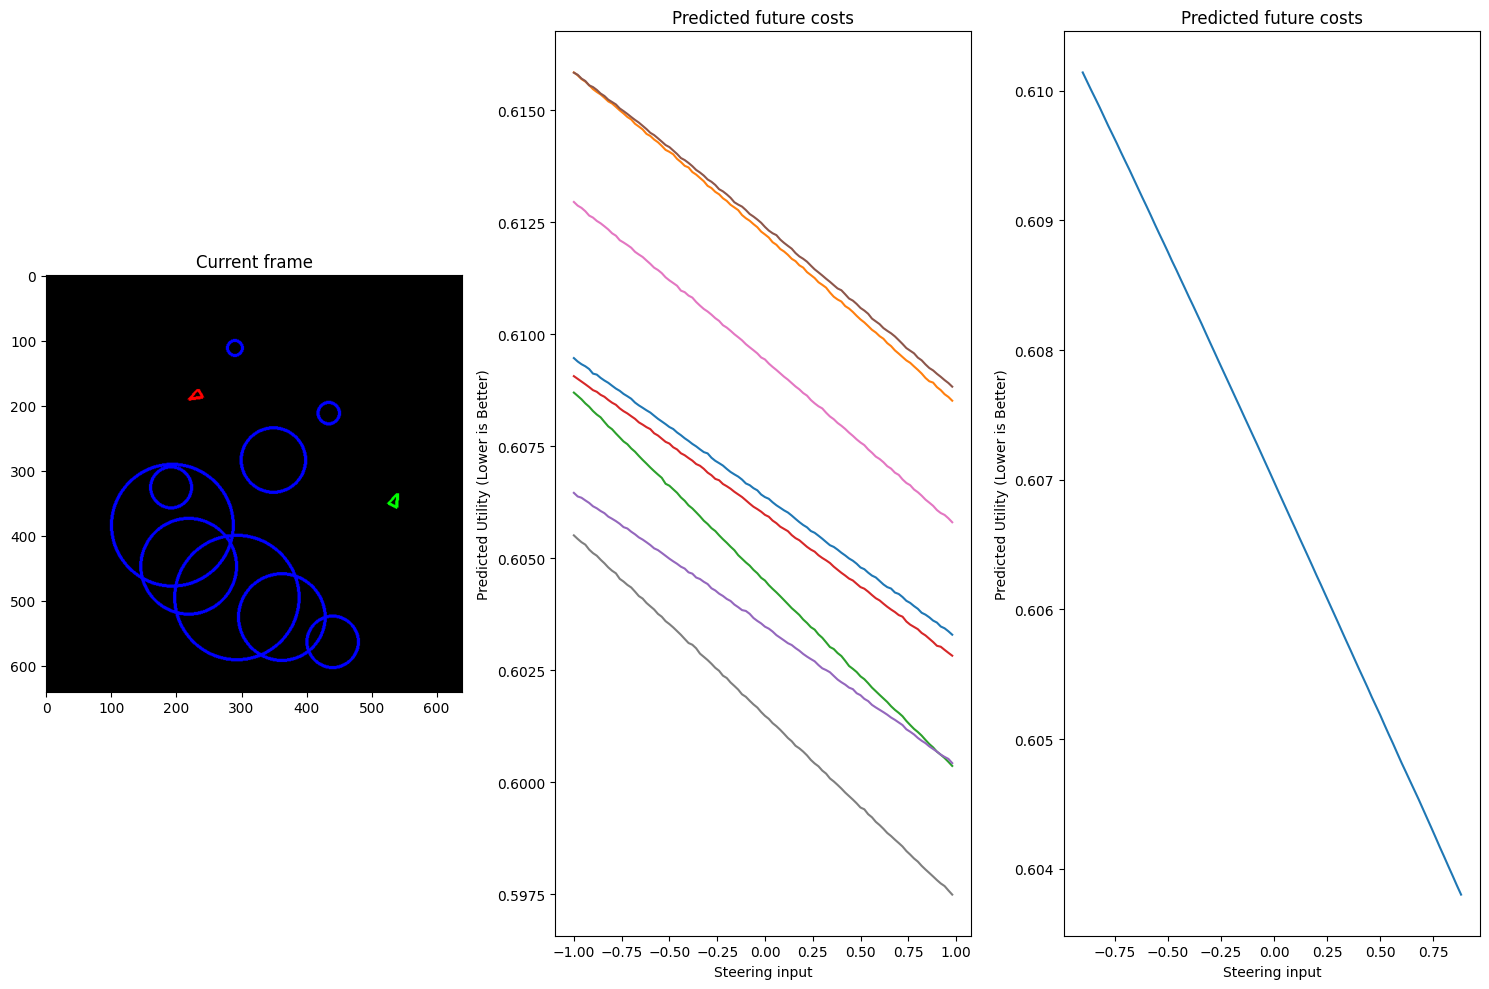

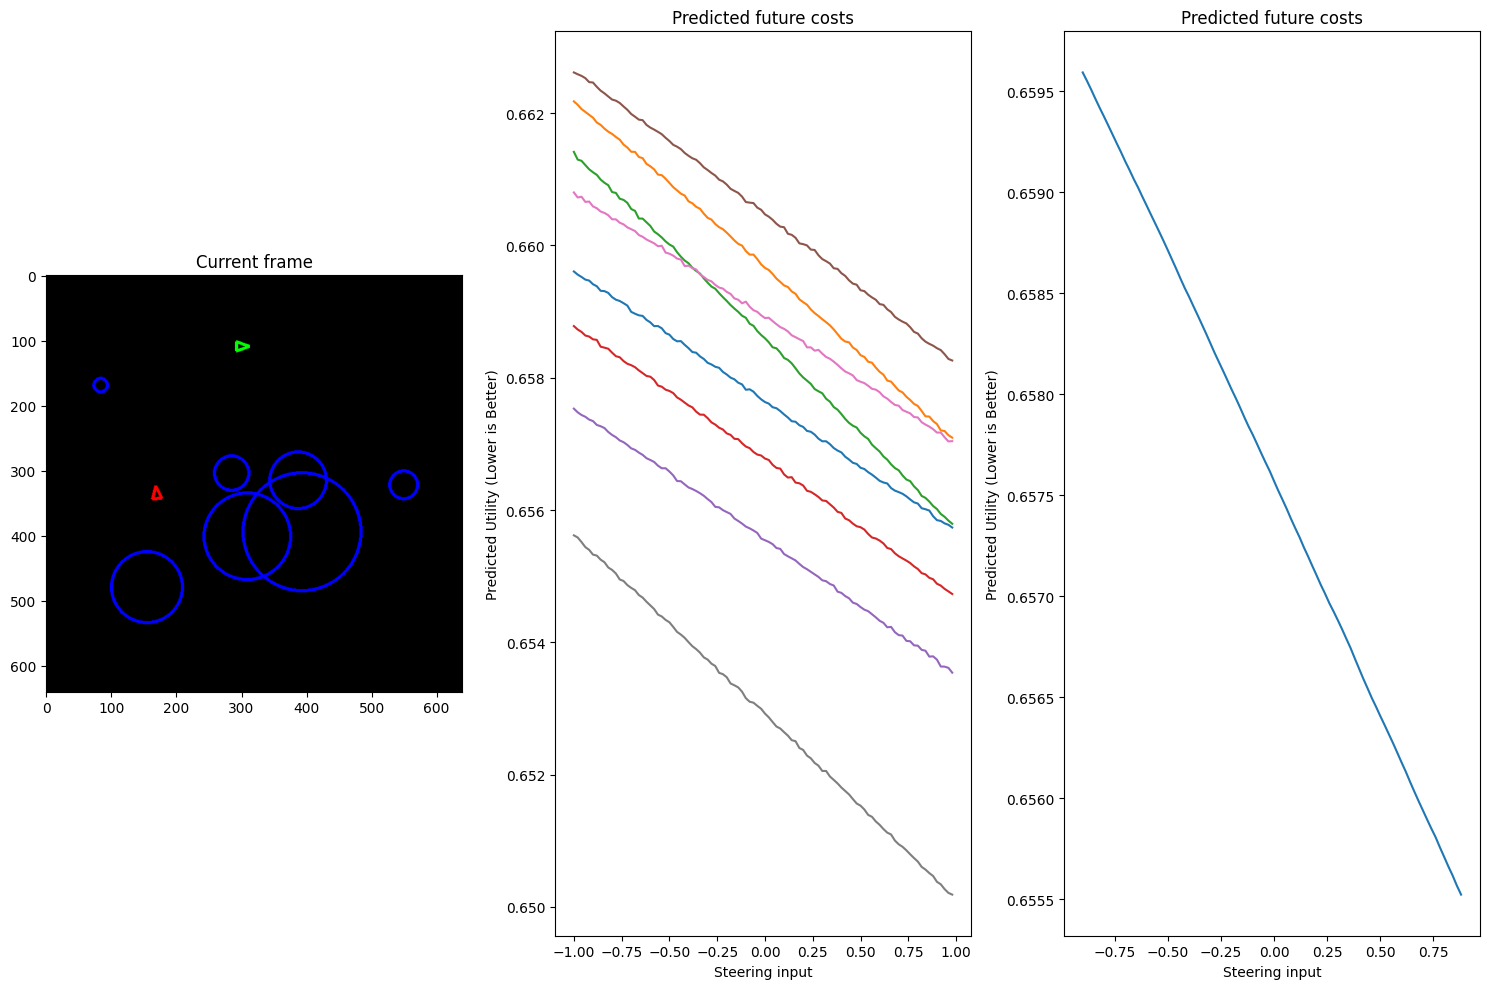

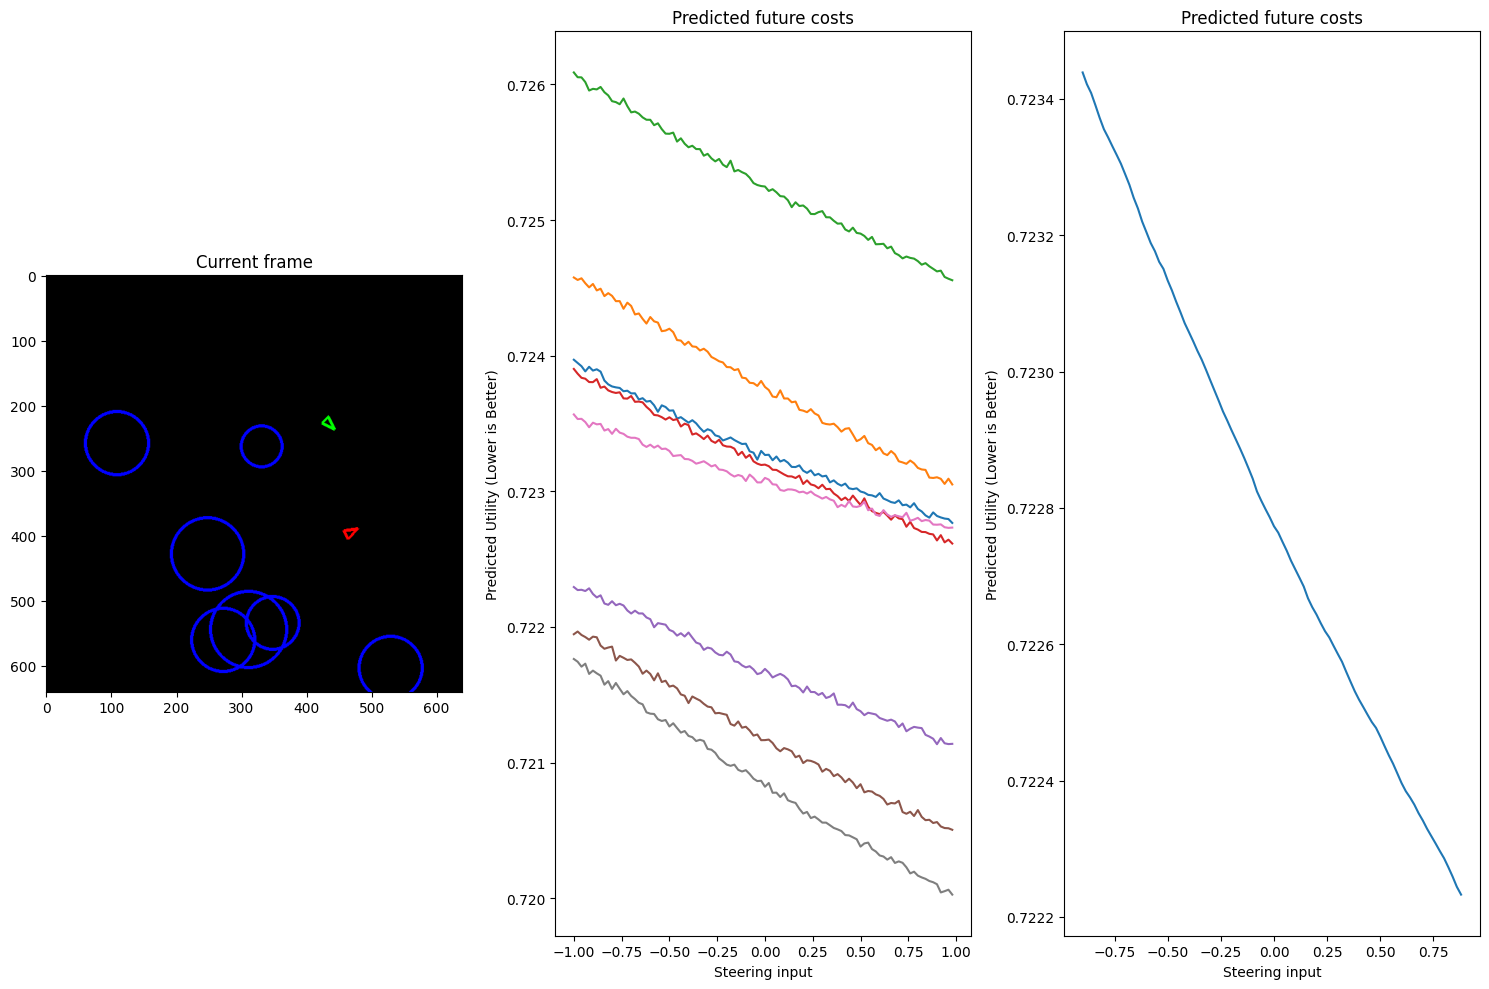

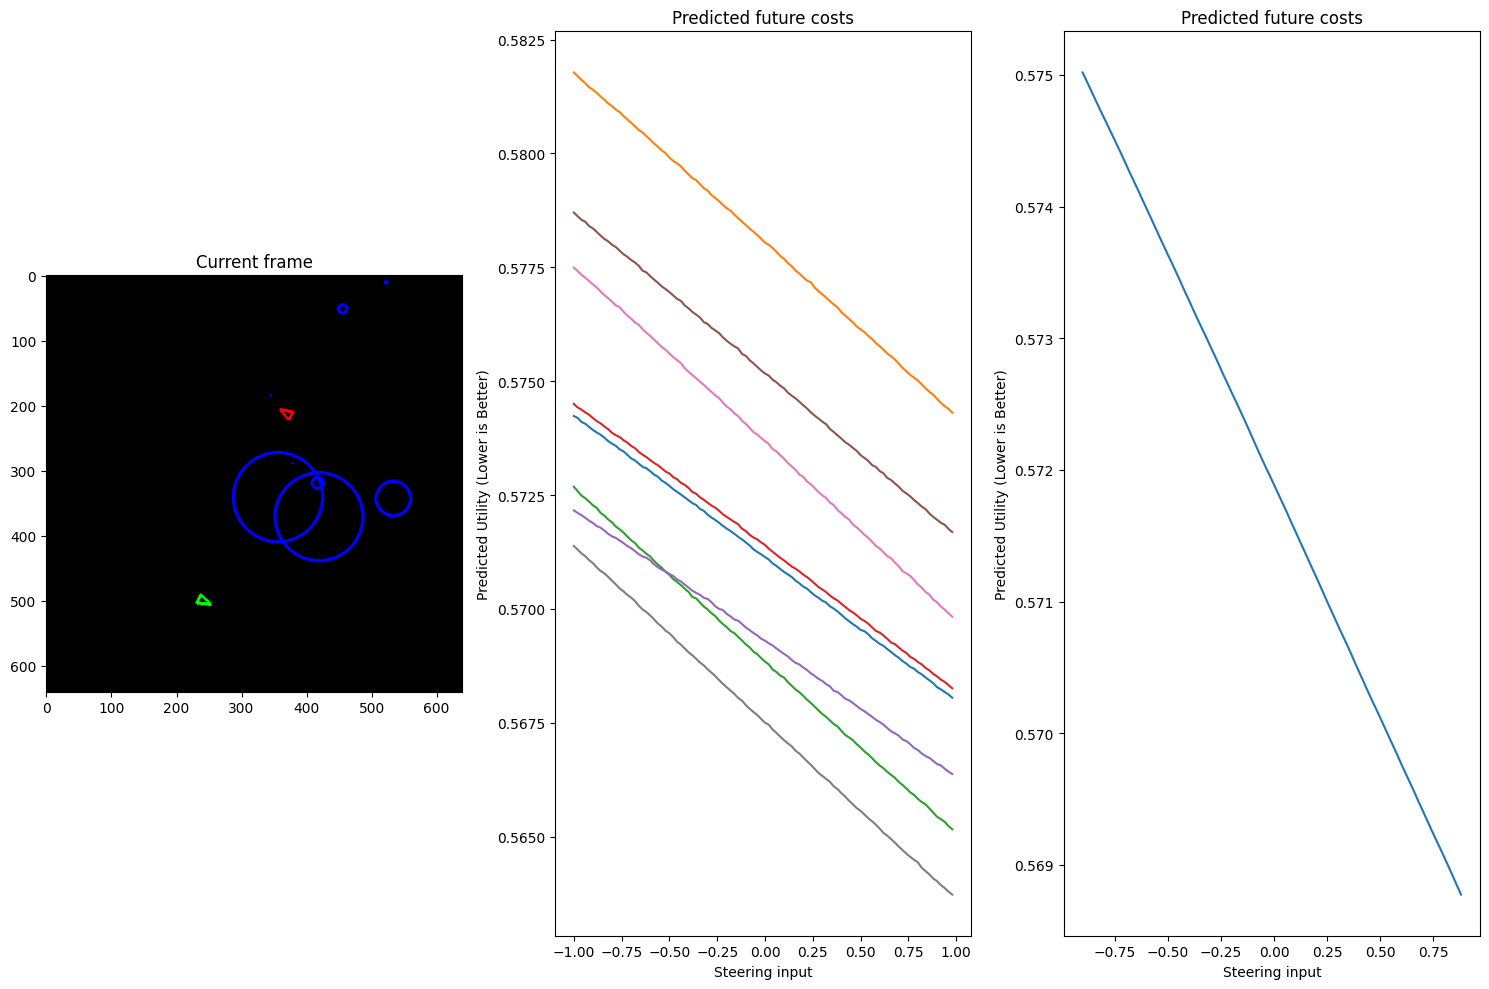

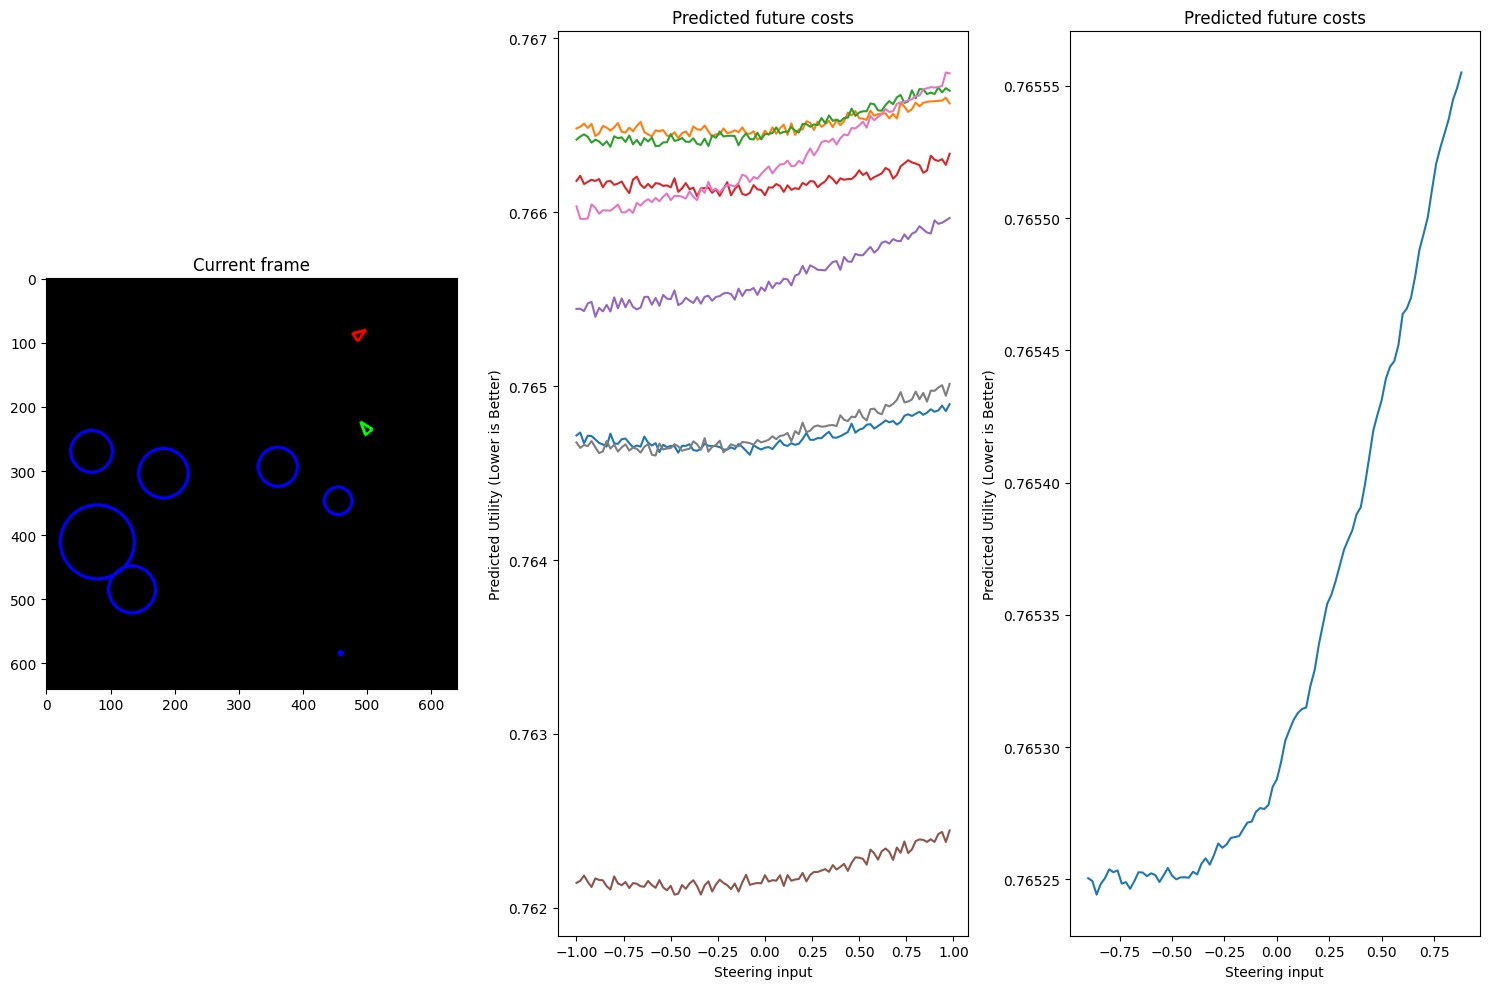

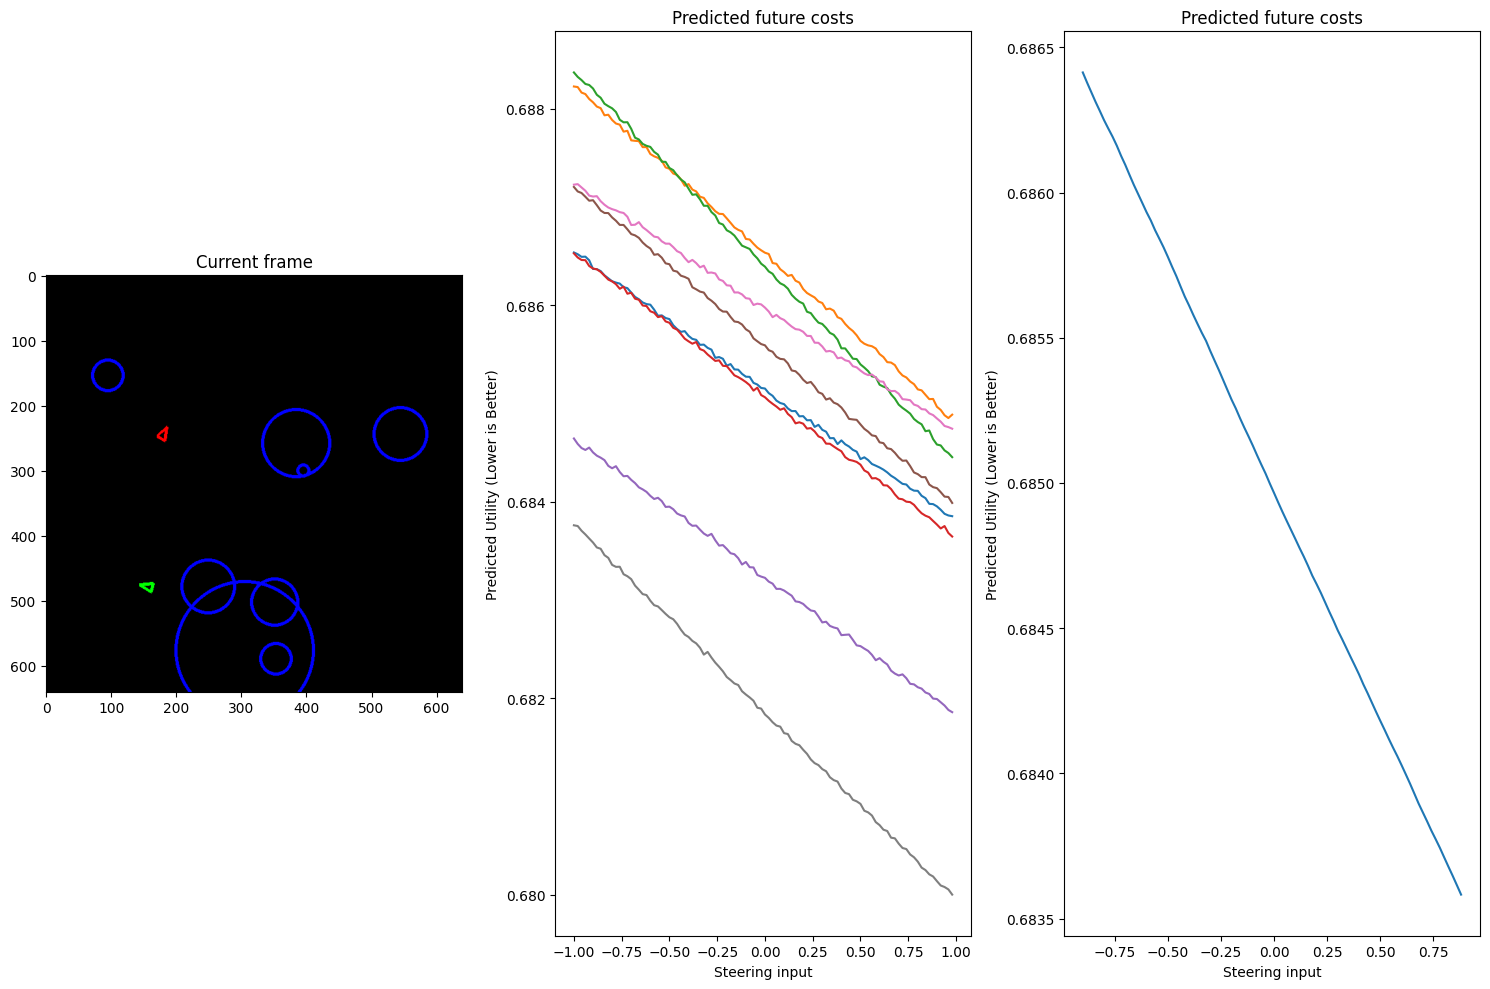

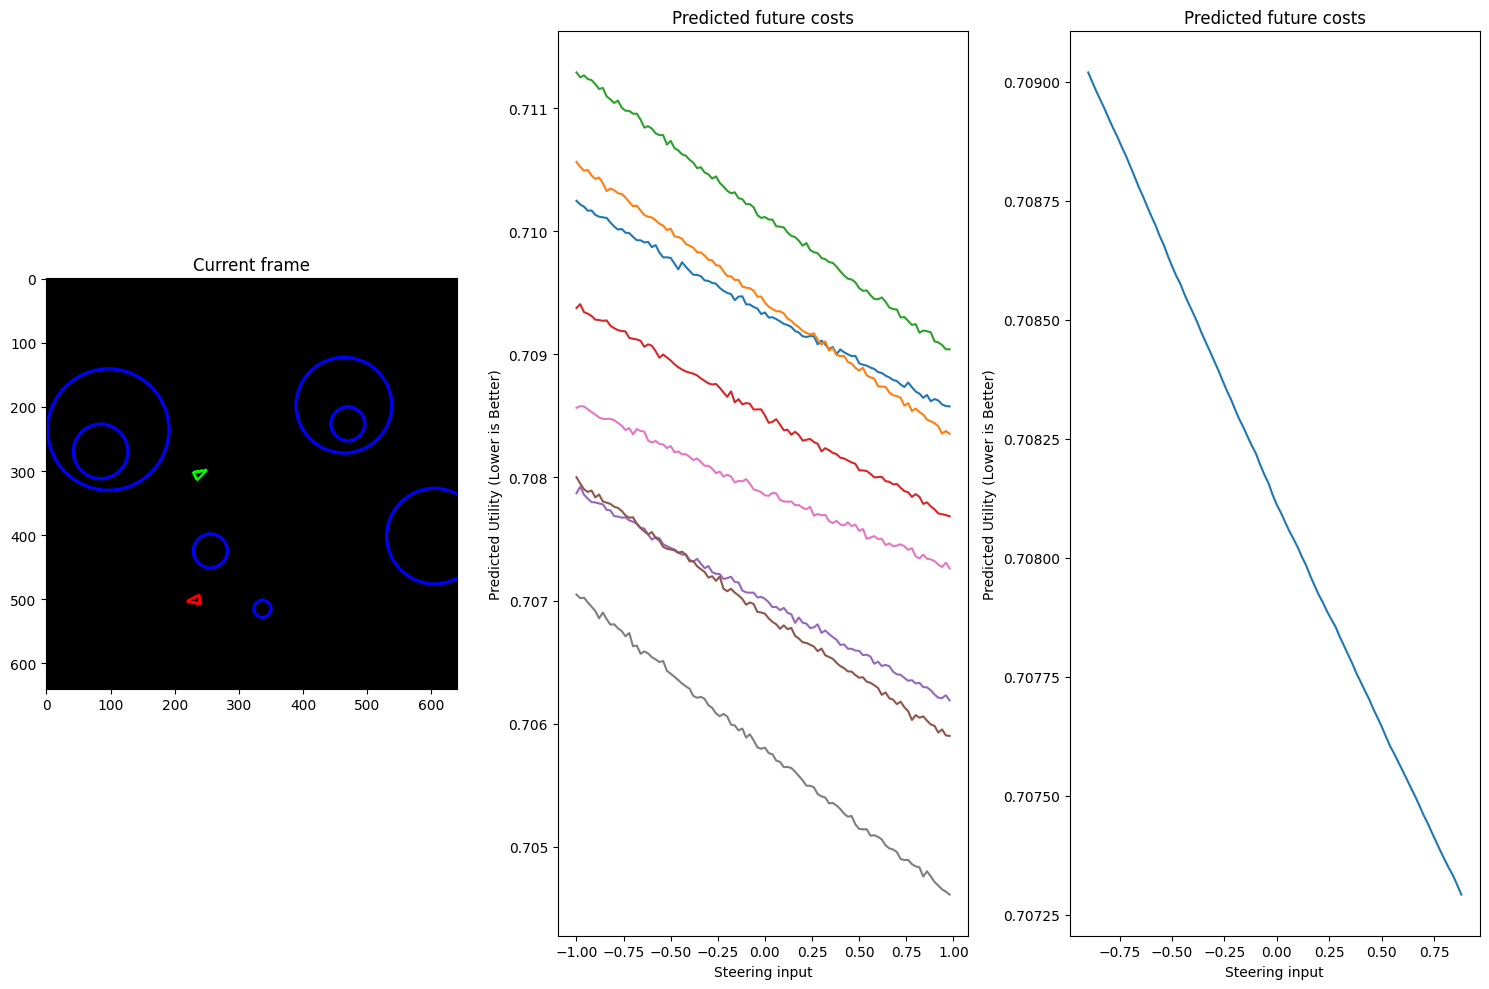

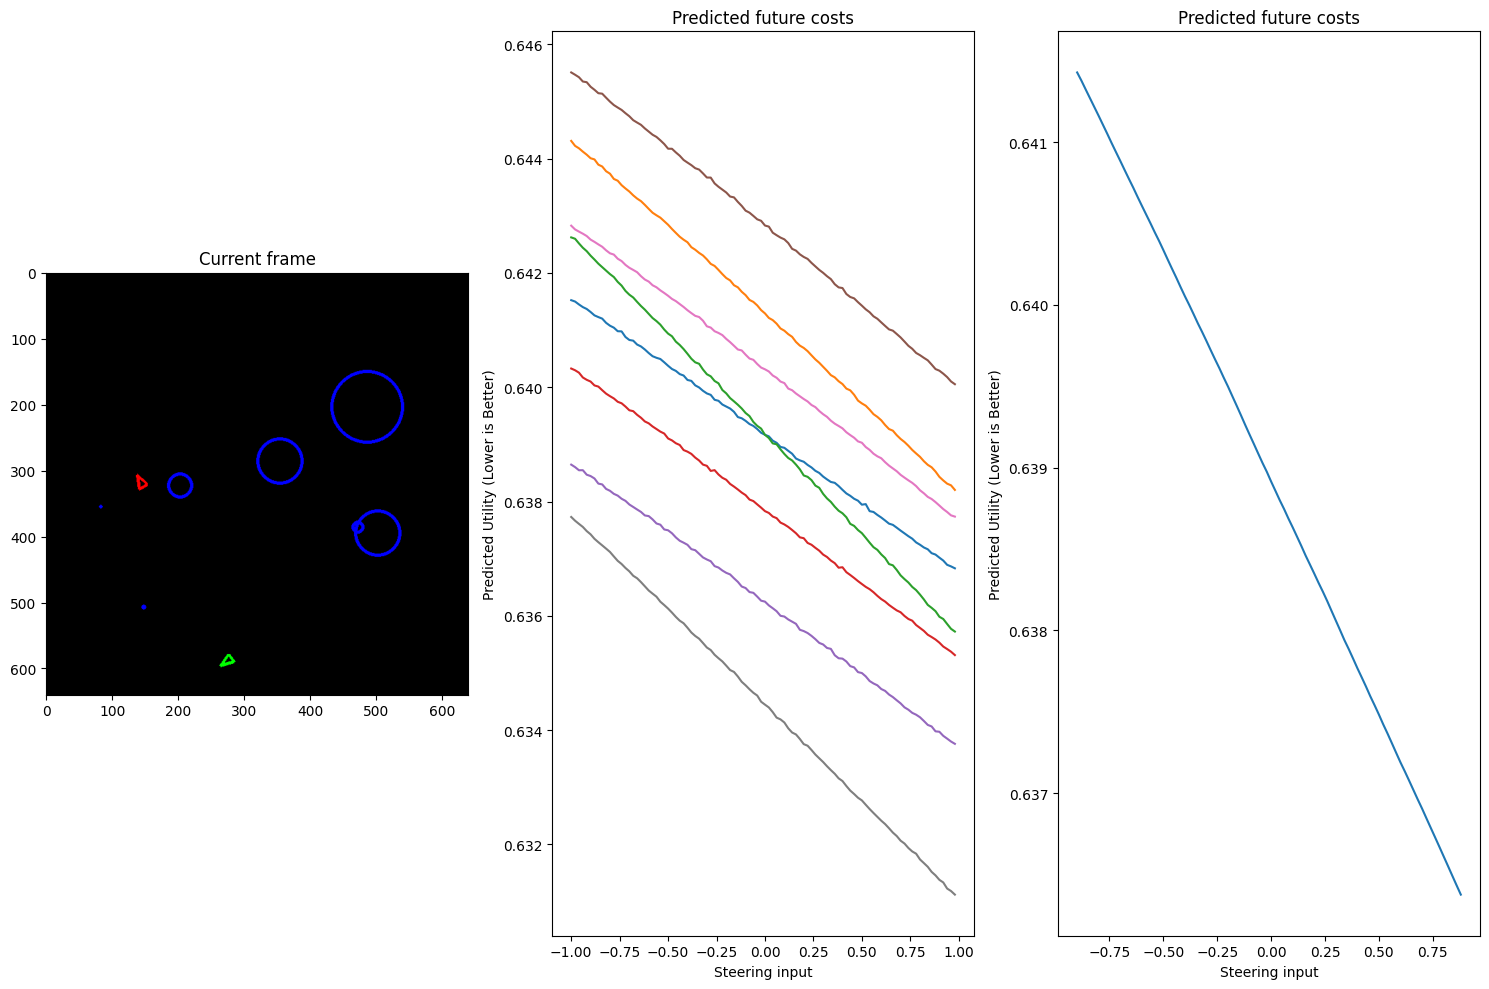

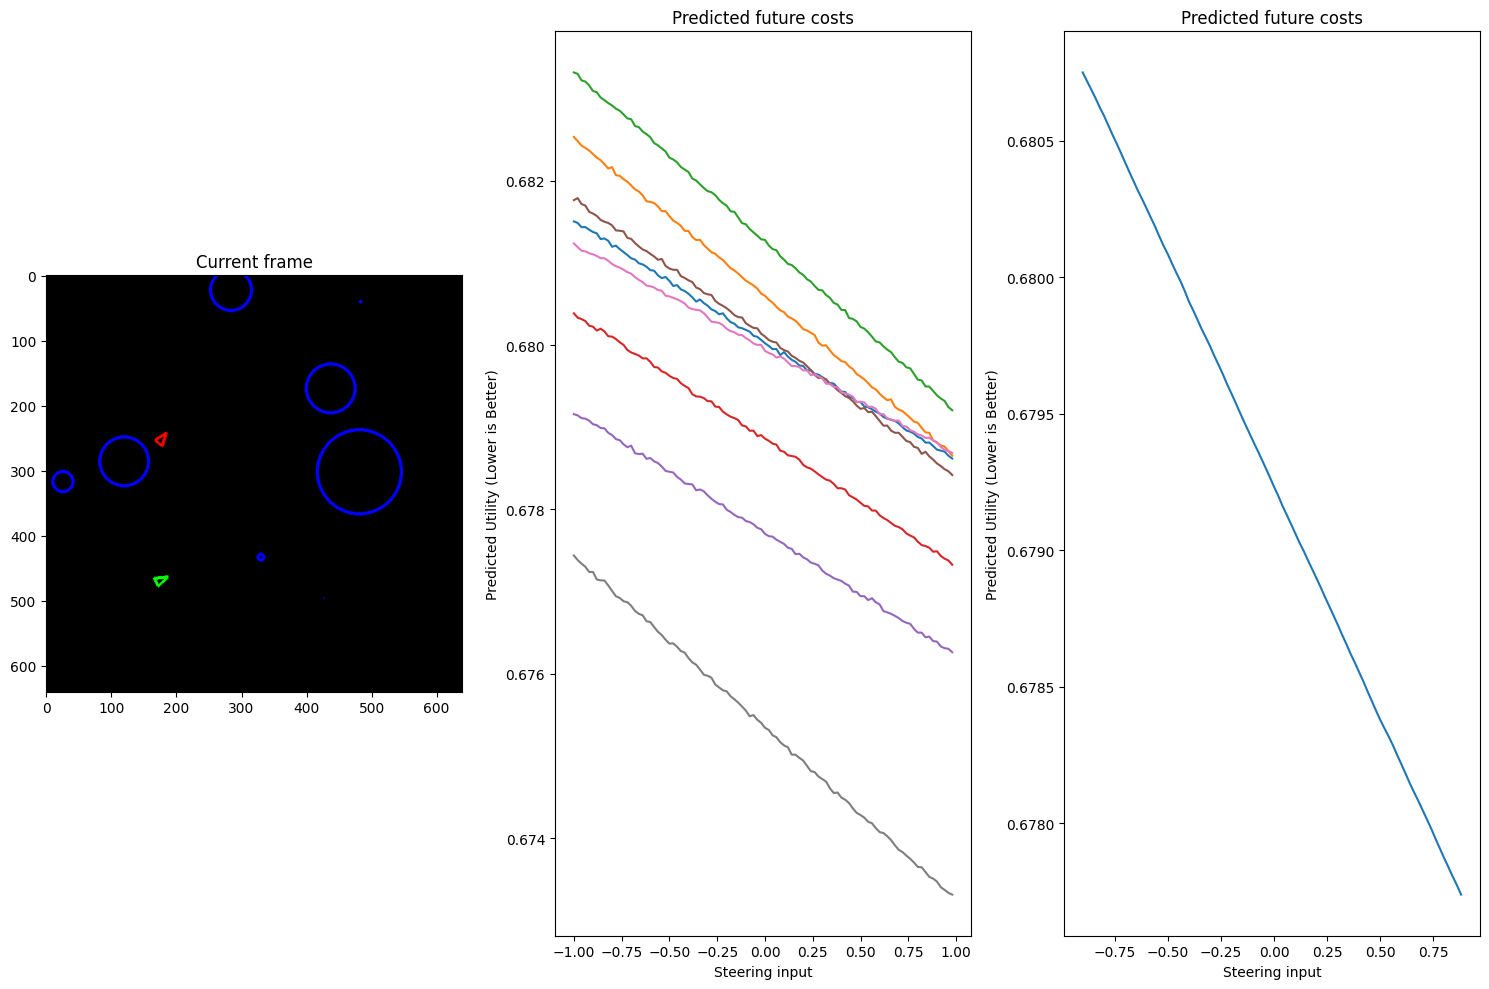

In [13]:
# Plot sanity test: how does turning effect score
import matplotlib.pyplot as plt

test_cc_ds = big_valid_ds.batch(16).take(1)

for elements in test_cc_ds.map(lambda w, x, y, z: (encoder(w), w, y, z)):
    move, costs, smoothed_costs = define_action(elements[0])
    for i in range(tf.shape(move)[0]):
        fig, ax = plt.subplots(1, 3, figsize=(15,10))

        # Plot image
        ax[0].imshow(elements[1][i].numpy().astype(float))
        ax[0].set_title("Current frame")

        # Plot scores for each action
        ax[1].plot(tf.range(NUM_POSSIBLE_ACTIONS)/(NUM_POSSIBLE_ACTIONS//2) - 1, costs[i])
        ax[1].set_title("Predicted future costs")
        ax[1].set_xlabel("Steering input")
        ax[1].set_ylabel("Predicted Utility (Lower is Better)")

        # Plot smoothed scores for each action
        num_actions = NUM_POSSIBLE_ACTIONS - 2 * ACTION_SPACE_SMOOTHING
        ax[2].plot((tf.range(num_actions) - (num_actions//2))/(NUM_POSSIBLE_ACTIONS//2), smoothed_costs[i])
        ax[2].set_title("Predicted future costs")
        ax[2].set_xlabel("Steering input")
        ax[2].set_ylabel("Predicted Utility (Lower is Better)")

        plt.tight_layout()
        plt.show()
    # print(, tf.shape(costs), tf.shape(smoothed_costs))

In [18]:
# Reverse the predicted embedings to locations

# Make reverser
embeding_reverser = models.Sequential()
embeding_reverser.add(layers.Input(shape=OUTPUT_SIZE + 1))
# embeding_reverser.add(layers.Dropout(CC_TOPLINE_DROPOUT))

# Add internal layers
for _ in range(CC_INTER_LAYERS):
    embeding_reverser.add(layers.Dense(CC_INTER_LAYER_SIZE, activation="elu",)) # kernel_regularizer='l2'))
    embeding_reverser.add(layers.Dropout(CC_DROPOUT))

embeding_reverser.add(layers.Dense(CC_INTER_LAYER_SIZE//2)) #, activation="elu"))
embeding_reverser.add(layers.Dense(CC_INTER_LAYER_SIZE//4)) #, activation="elu"))
embeding_reverser.add(layers.Dense(4, activation="sigmoid")) #, activation="elu"))

embeding_reverser.summary()

# Train reverser
apply_encoder_and_combine = lambda w, x, y, z: (tf.concat([tf.cast(encoder(w), tf.float16), x], axis=-1), tf.concat([y, z], axis=-1)/IMG_INPUT_SHAPE[0])
print(big_debug_train_ds)
reverser_train_ds = big_debug_train_ds.batch(BATCH_SIZE).map(apply_encoder_and_combine, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()
reverser_valid_ds = big_debug_valid_ds.batch(BATCH_SIZE).map(apply_encoder_and_combine, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()

embeding_reverser.compile(optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mse"])

embeding_reverser.fit(
    reverser_train_ds,
    validation_data=reverser_valid_ds,
    epochs=MAX_EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=MAX_EPOCHS//10, restore_best_weights=True)]
)

# Predict, then plot reverser
test_cc_ds = big_valid_ds.batch(16).take(1)
for elements in test_cc_ds.map(lambda w, x, y, z: (encoder(w), w, y, z)):
    predictions, actions = define_action(elements[0], num_actions=5, ret_predictions=True)
    num_samples = tf.shape(predictions)[1]
    print(tf.shape(predictions))
    poses = embeding_reverser(tf.reshape(predictions, (5 * num_samples * PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE)))
    poses = tf.reshape(poses, (5, num_samples, PRED_POSSIBLE_OUTCOMES, 4)) * IMG_INPUT_SHAPE[0]
    for i in range(num_samples):
        fig, axs = plt.subplots(1, 5, figsize=(15, 6))
        for j in range(5):
            axs[j].set_title(actions[j][0].numpy())
            axs[j].imshow(elements[1][i].numpy().astype(float))
            axs[j].axis("off")
            axs[j].scatter(poses[j, i, :, 0], poses[j, i, :, 1], c="red")
            axs[j].scatter(poses[j, i, :, 2], poses[j, i, :, 3], c="green")
        plt.show()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 128)               8448      
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 128)               16512     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 128)               16512     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_29 (Dense)            (None, 128)              

KeyboardInterrupt: 